In [33]:
import seaborn as sns
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import janitor 
from obspy.signal.trigger import classic_sta_lta
from scipy.fft import fft, ifft, fftfreq
from scipy import signal, ndimage


In [34]:
class SismicDataset(Dataset):
    def __init__(self, max_length=572427):
        # Cargar el catálogo CSV
        self.cat = pd.read_csv('./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
        self.data_directory = './data/lunar/training/data/S12_GradeA'
        self.max_length = max_length  # Define la longitud máxima de las secuencias

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, idx):
        # Obtener los datos de la fila correspondiente
        row = self.cat.iloc[idx]
        test_filename = row['filename']
        arrival_time_rel = row['time_rel(sec)']

        # Construir la ruta al archivo .mseed
        mseed_file = os.path.join(self.data_directory, f'{test_filename}.mseed')

        # Leer los datos de la señal usando obspy
        minfreq = 0.1
        maxfreq = 3.0

        st = read(mseed_file)
        st_filt = st.copy()
        st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
        tr_filt = st_filt.traces[0].copy()
        tr_times_filt = tr_filt.times()
        tr_data_filt = tr_filt.data
        f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate, nperseg=2000, noverlap=1800)
        
        diff = np.abs(t - arrival_time_rel)
        index = np.argmin(diff)
        # Convertir los datos a tensores
        
        label = arrival_time_rel

        return tr_data_filt, tr_times_filt, f, t, sxx,label, index 

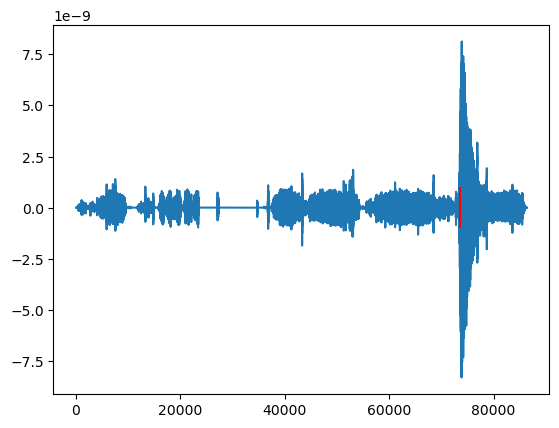

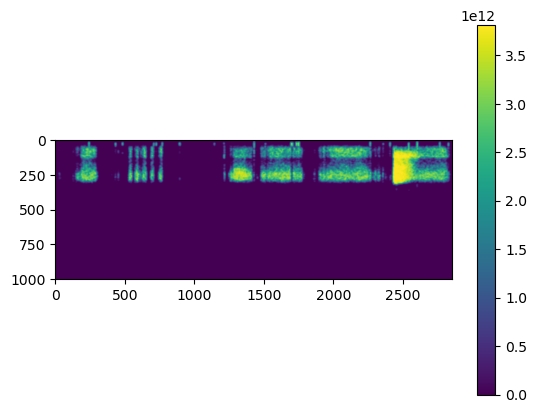

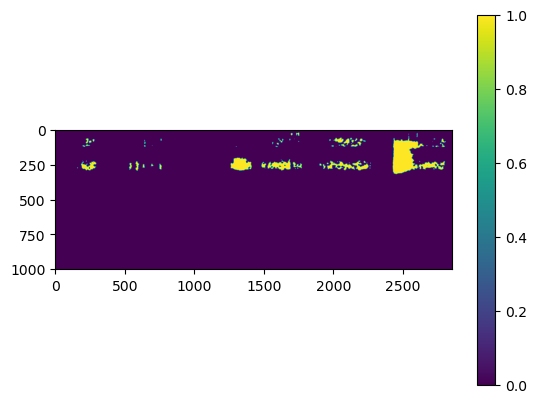

73509.43396226416


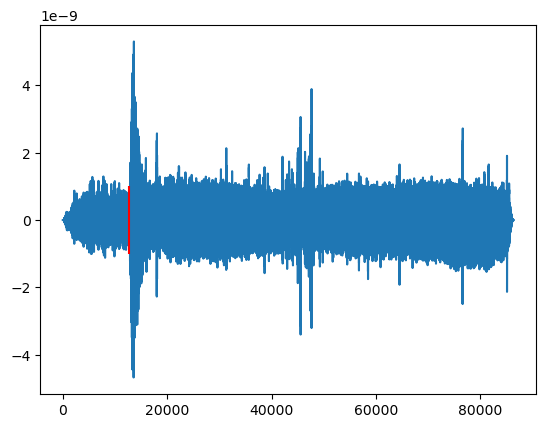

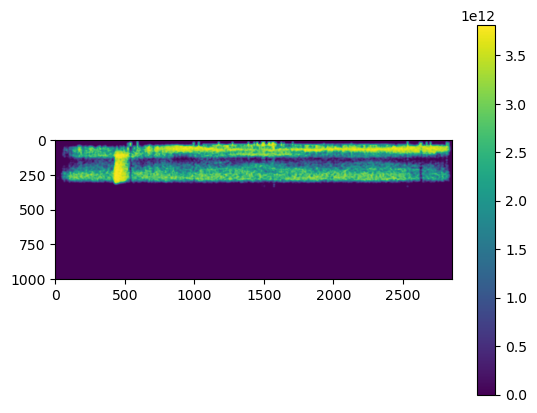

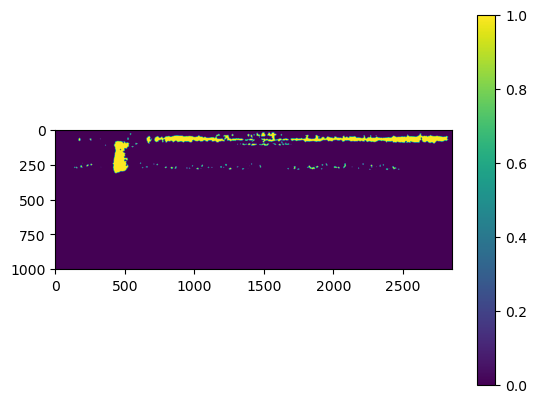

12709.433962264151


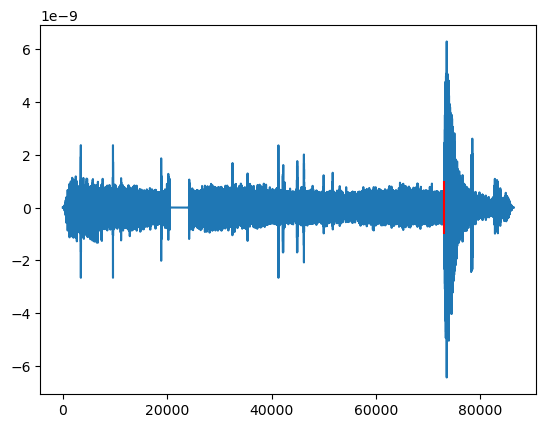

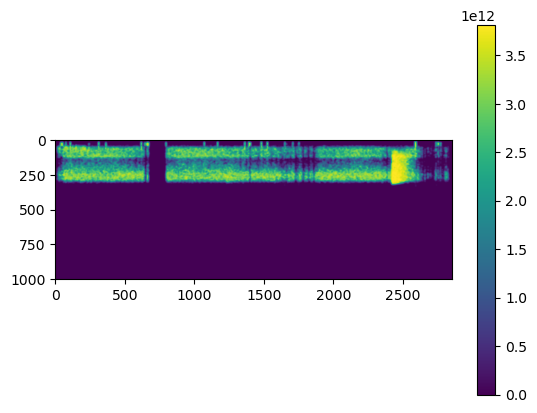

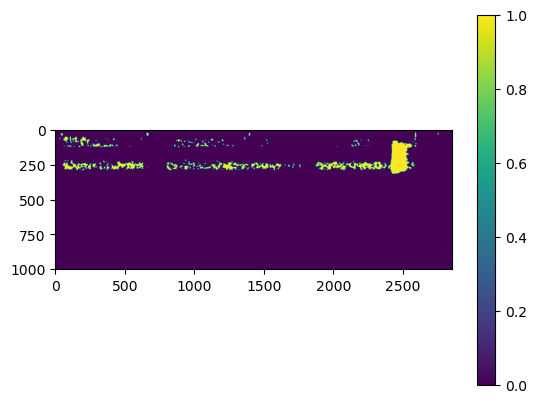

73026.41509433962


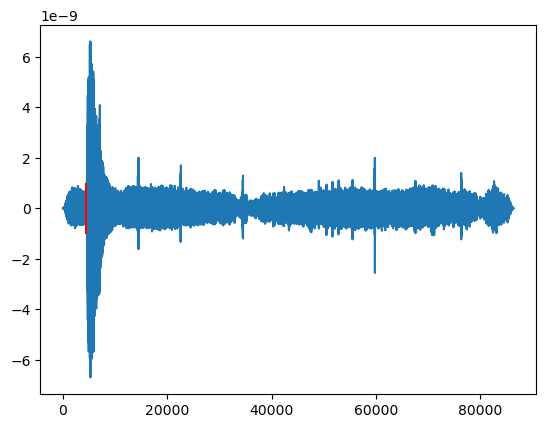

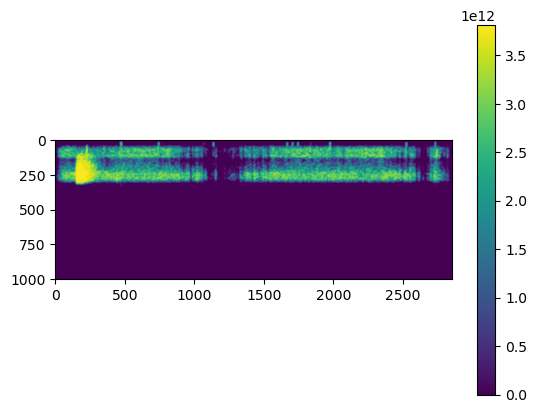

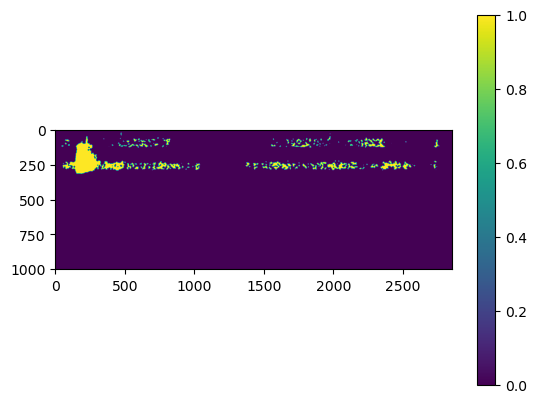

4437.735849056604


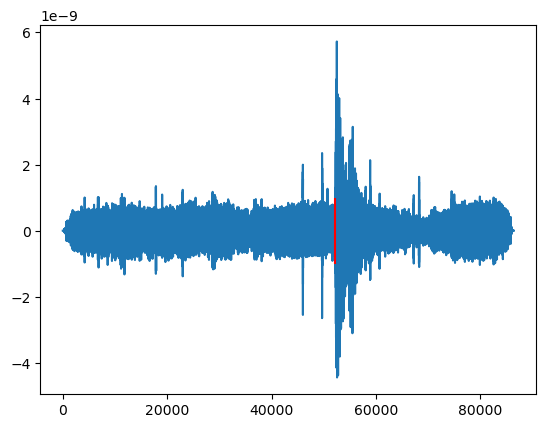

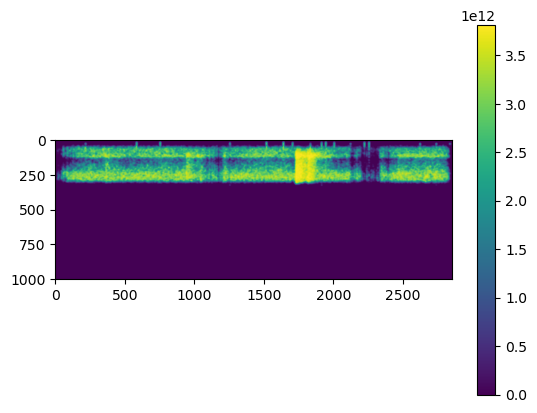

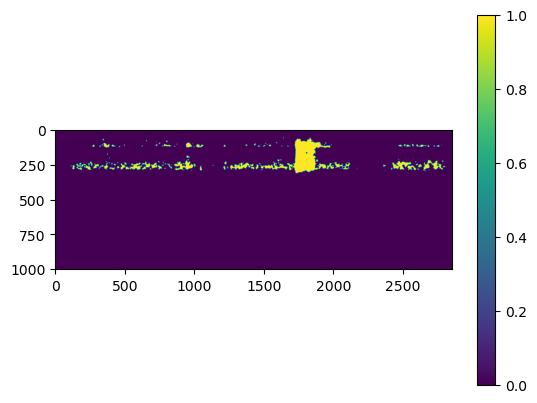

52135.84905660377


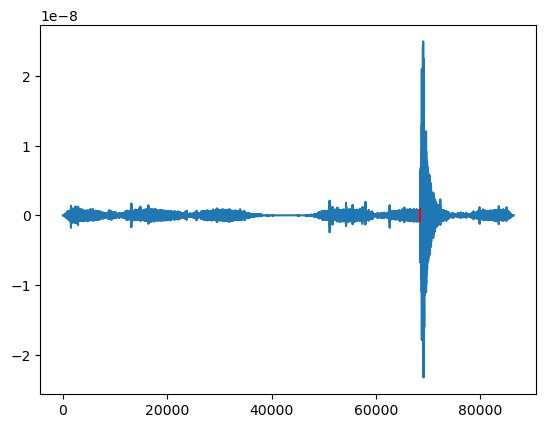

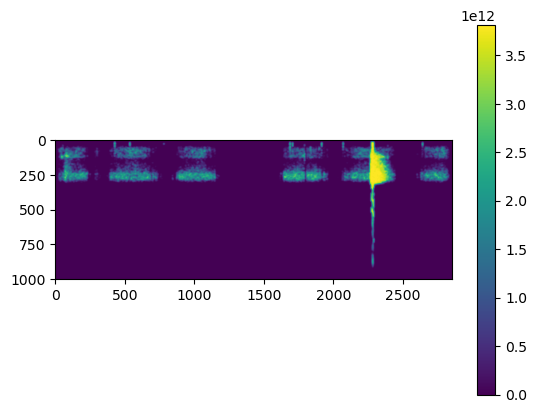

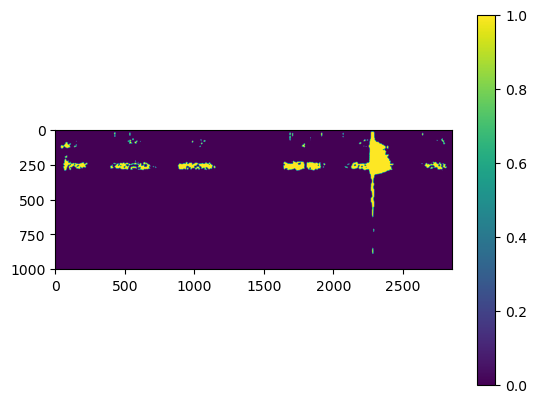

68407.54716981133


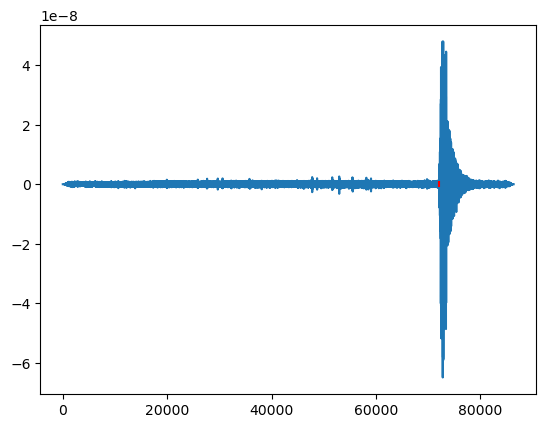

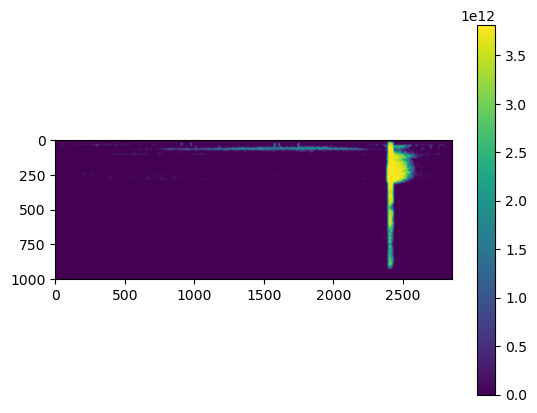

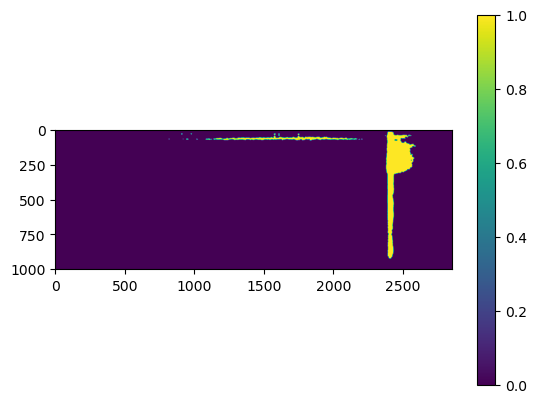

72060.37735849057


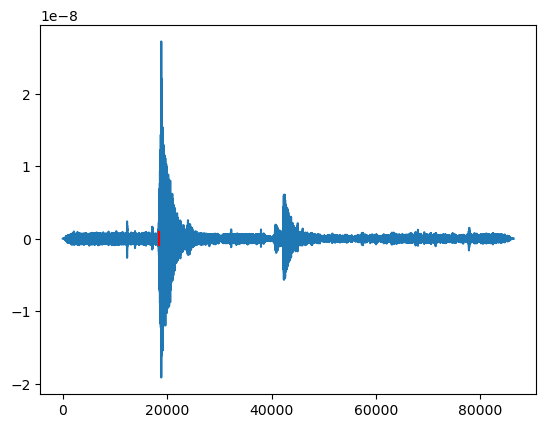

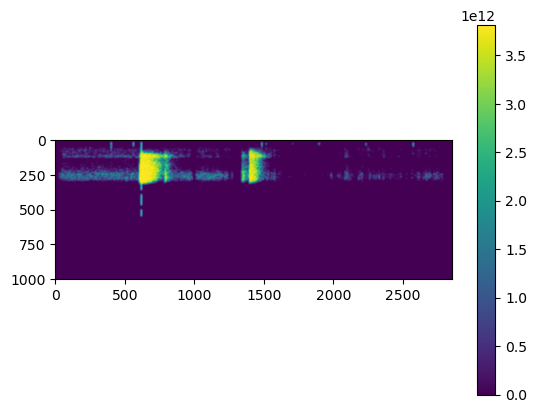

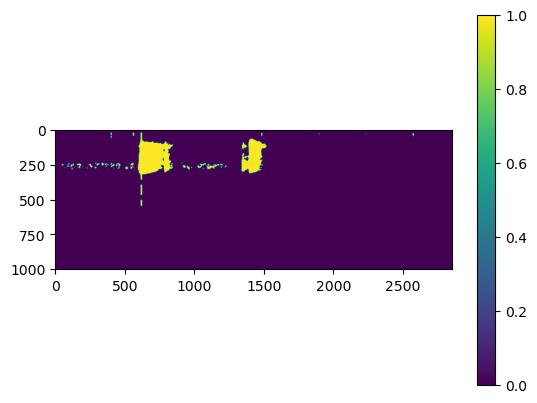

18354.716981132075


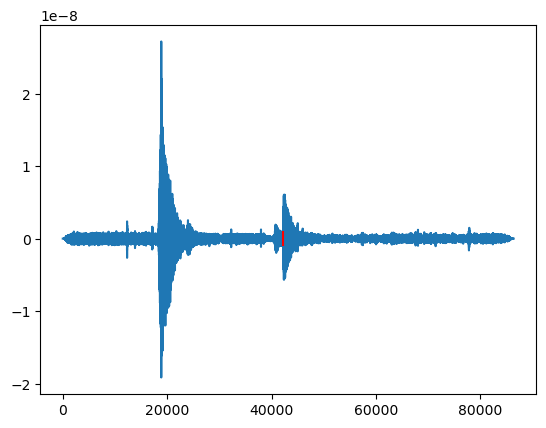

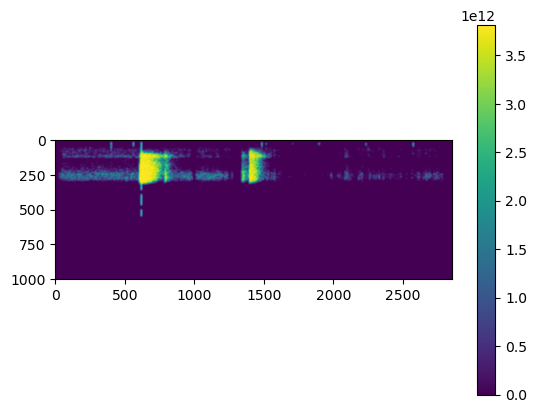

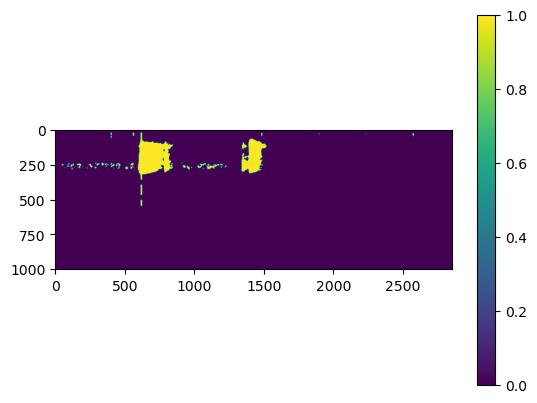

42233.96226415094


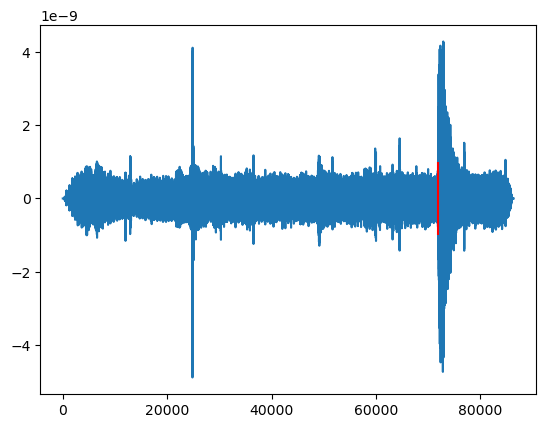

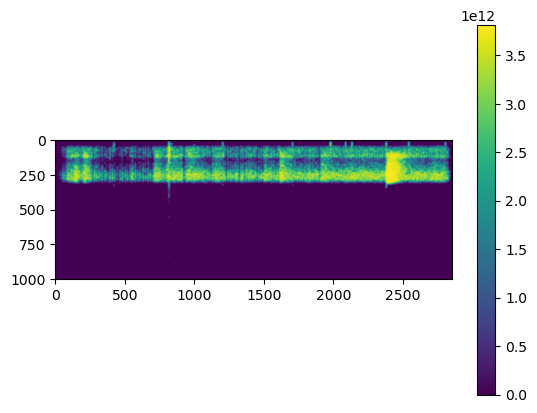

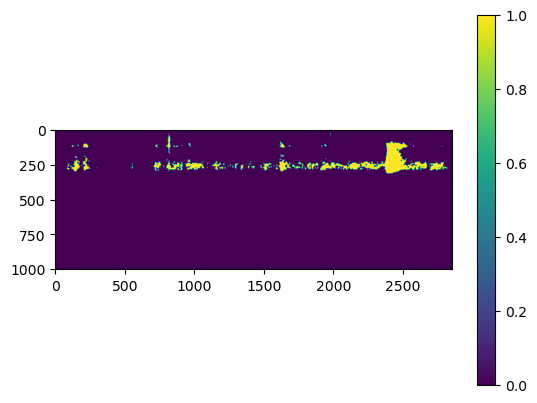

71818.8679245283


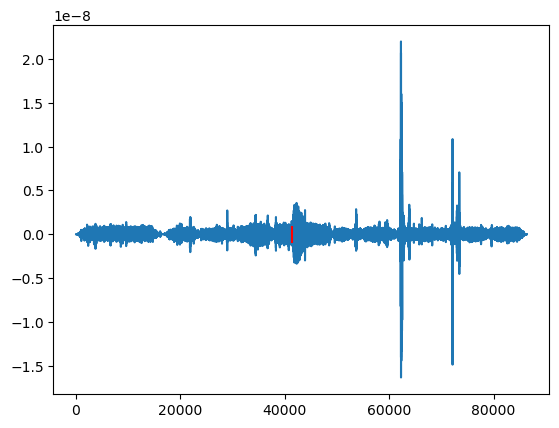

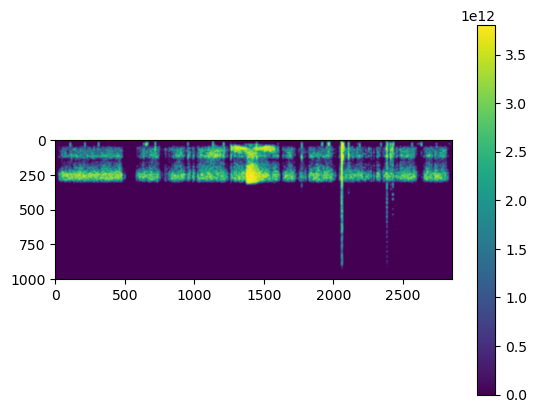

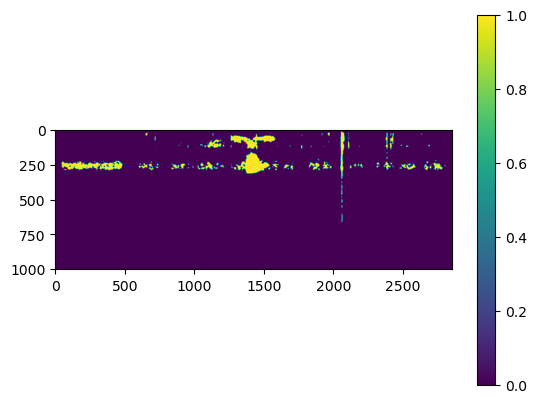

41449.056603773584


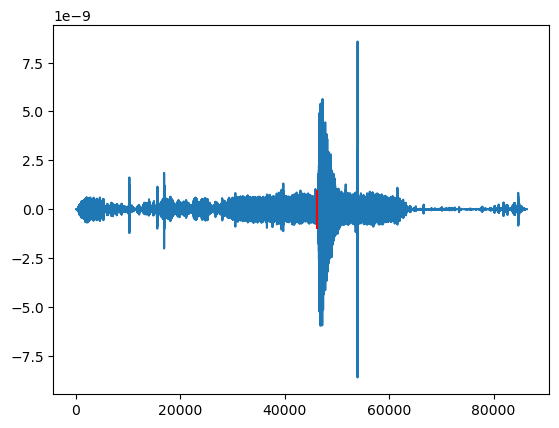

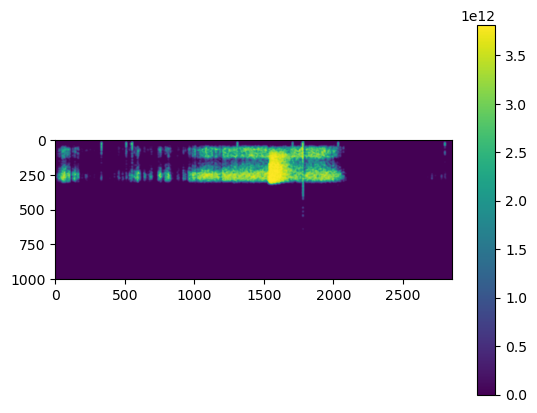

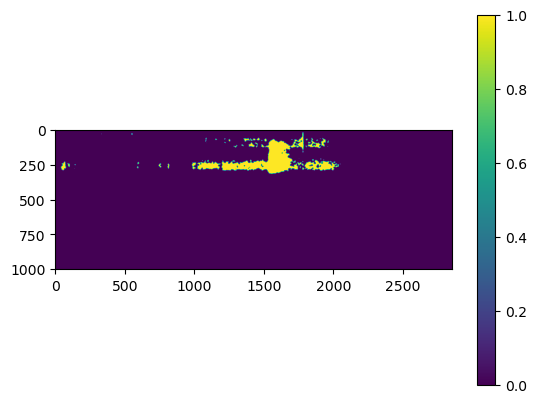

46188.67924528302


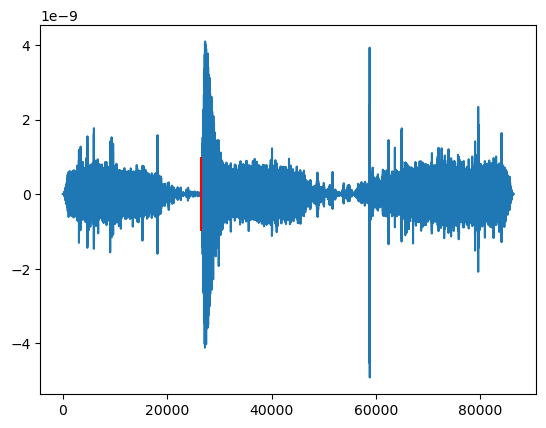

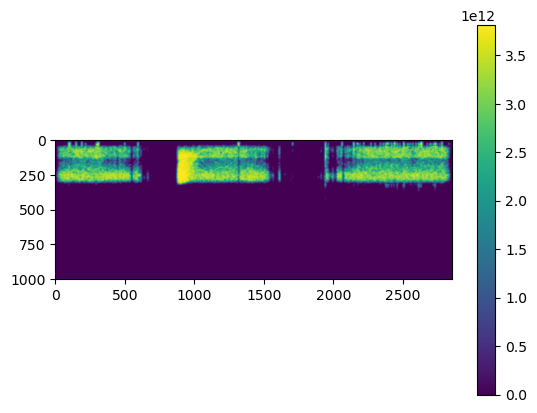

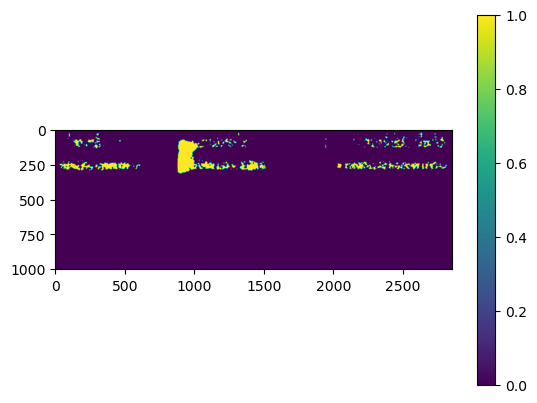

26505.66037735849


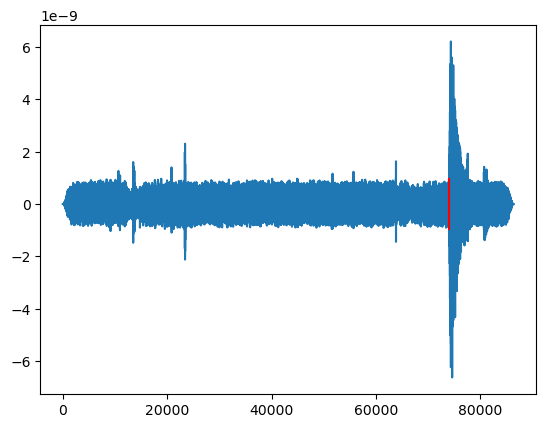

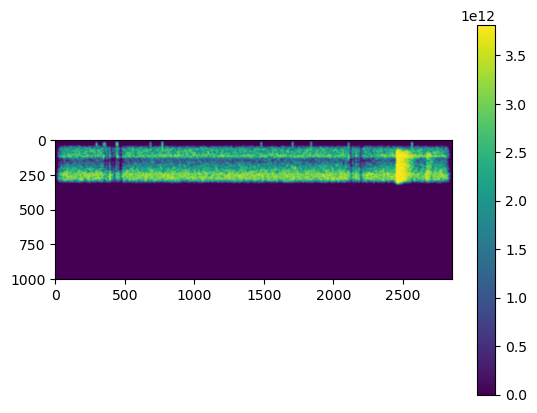

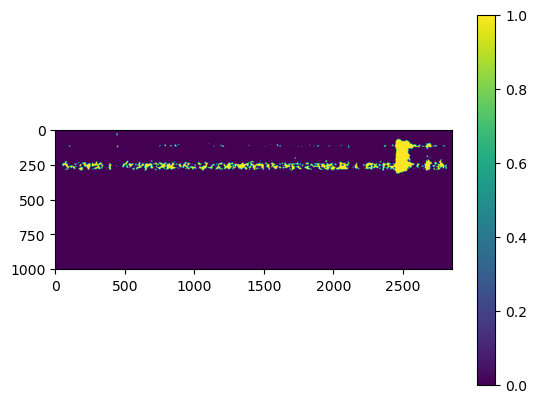

74052.83018867925


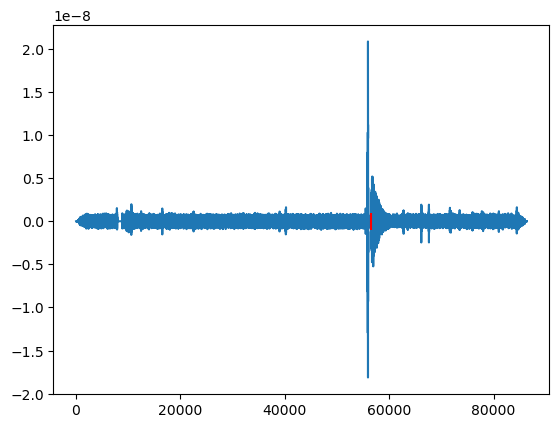

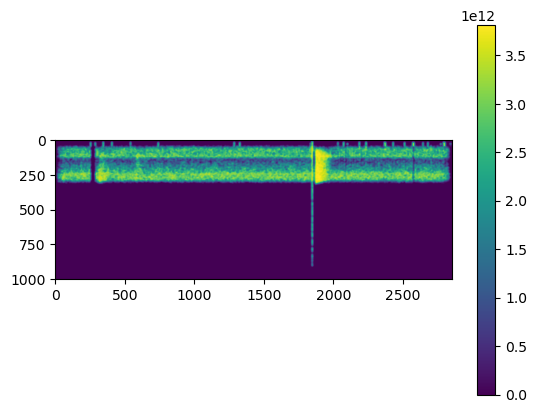

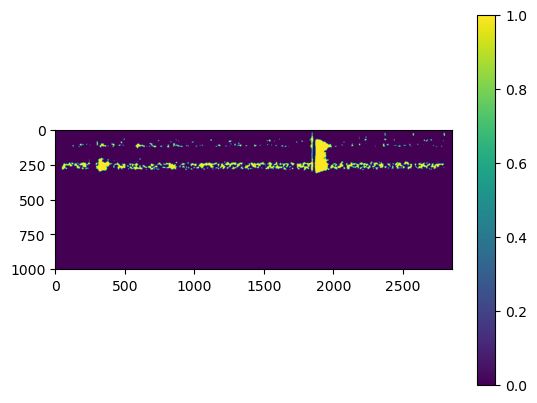

56452.83018867925


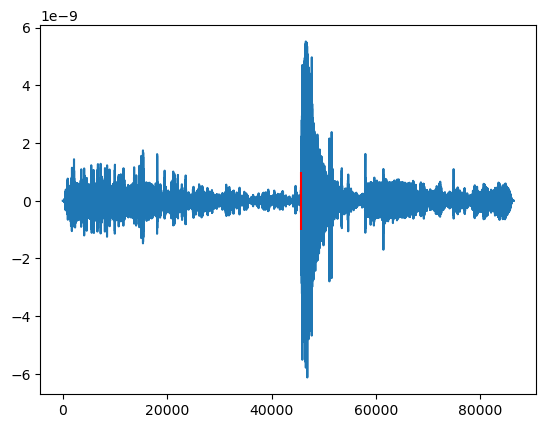

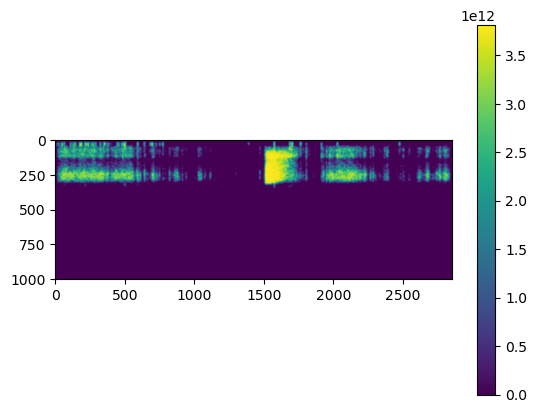

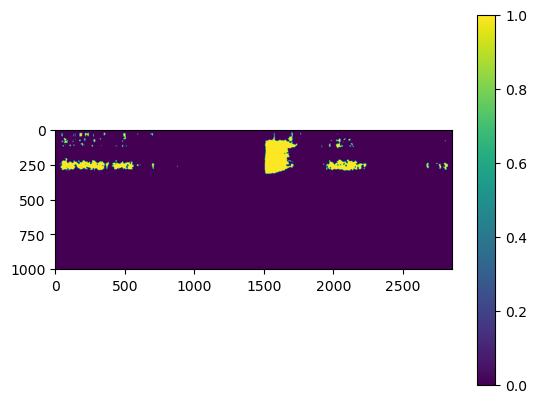

45584.90566037736


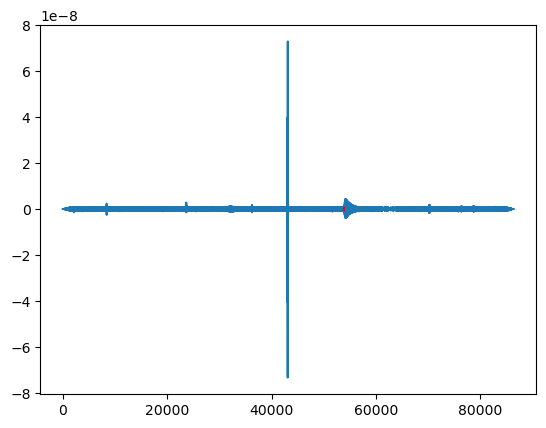

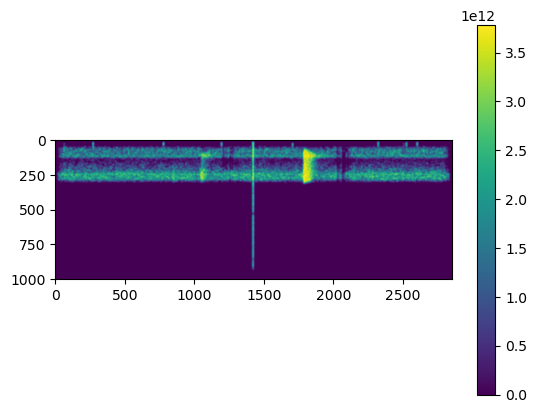

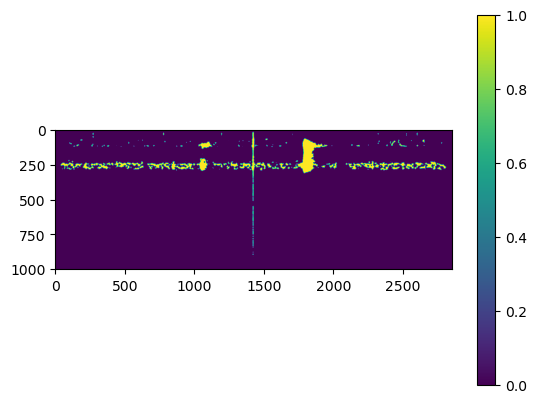

53947.16981132075


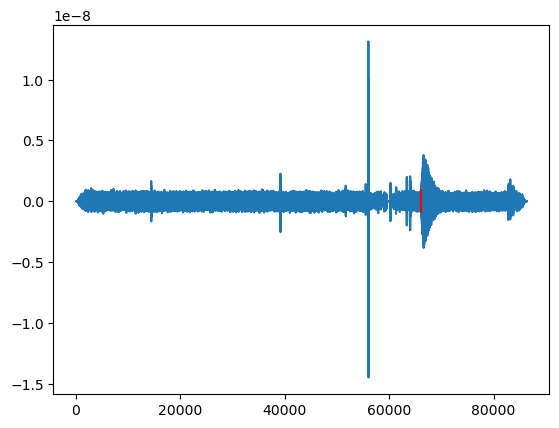

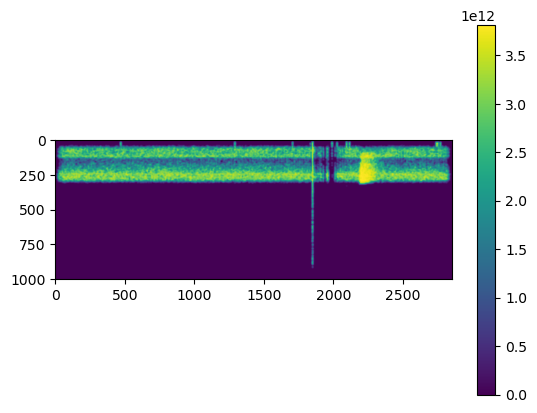

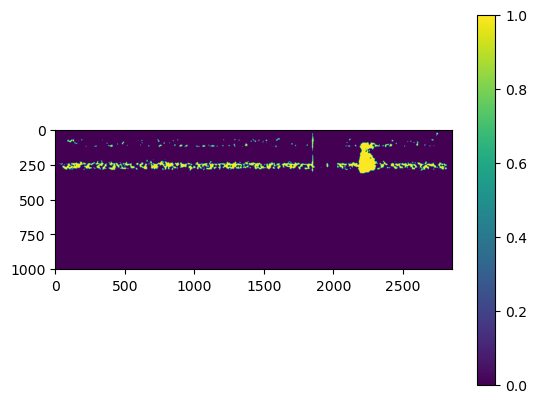

66052.83018867925


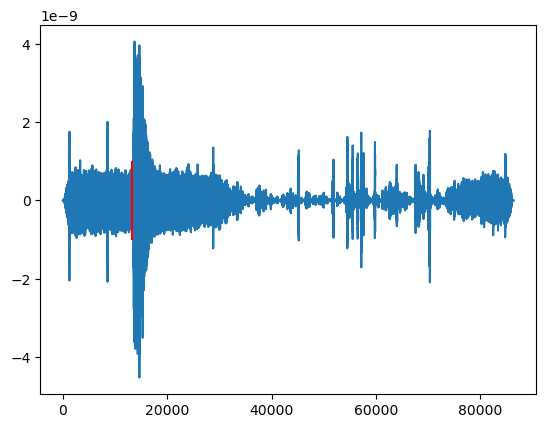

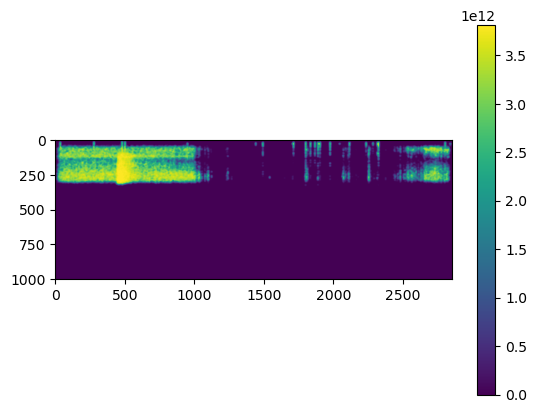

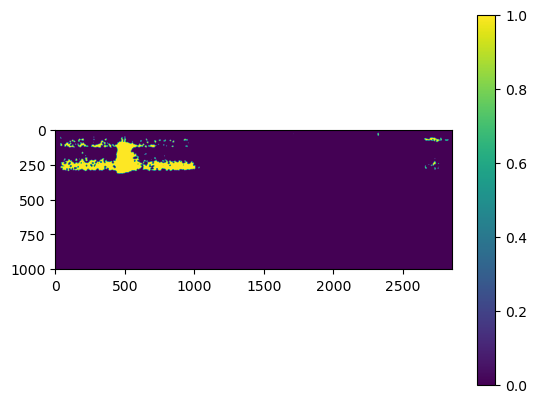

13313.207547169812


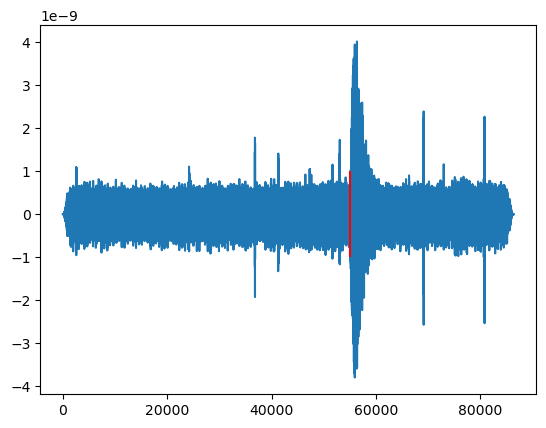

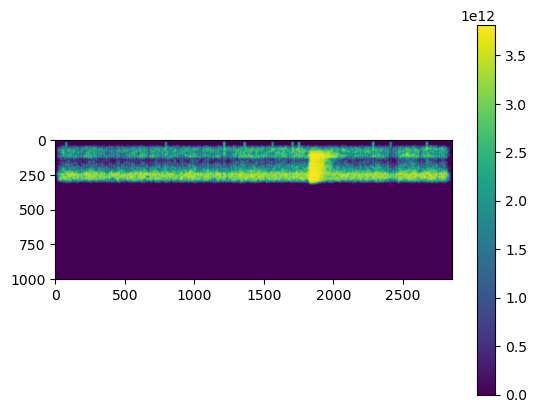

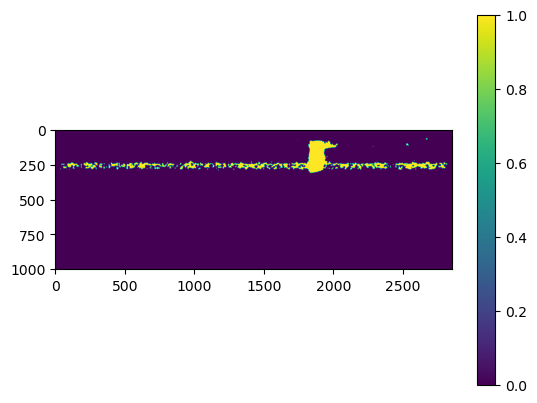

55094.339622641506


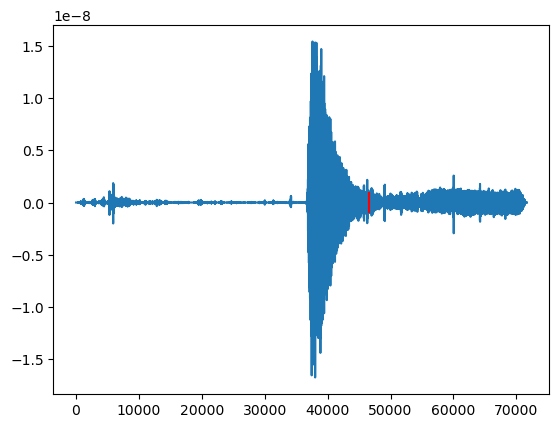

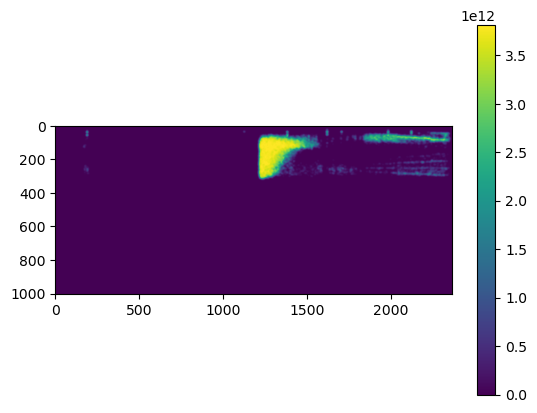

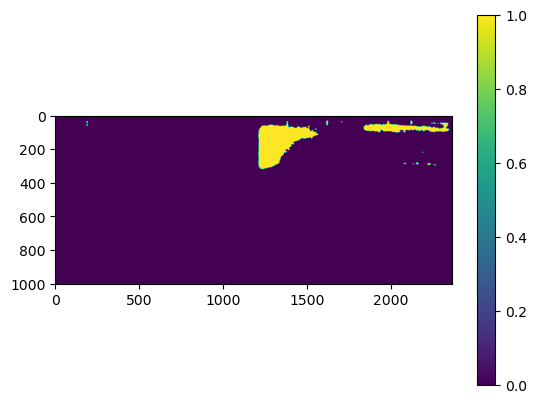

46490.56603773585


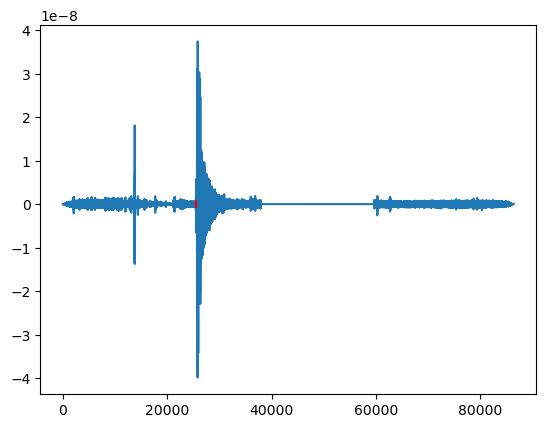

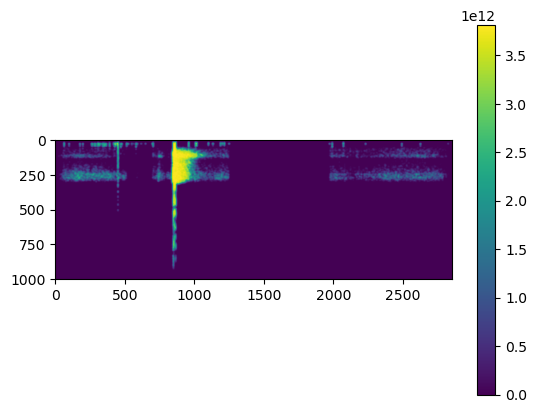

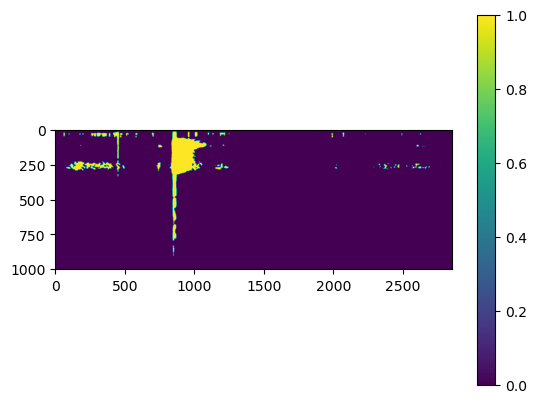

25449.056603773584


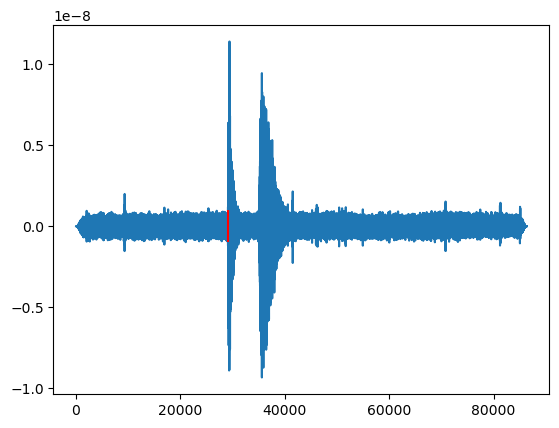

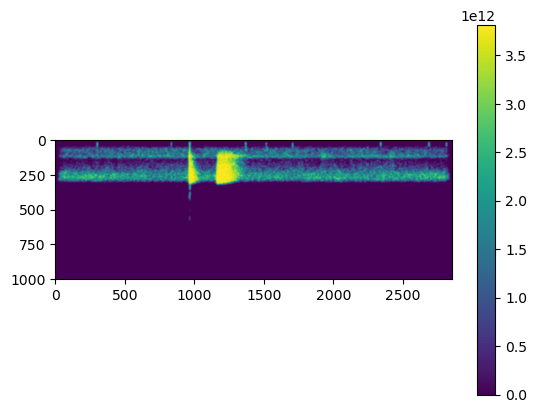

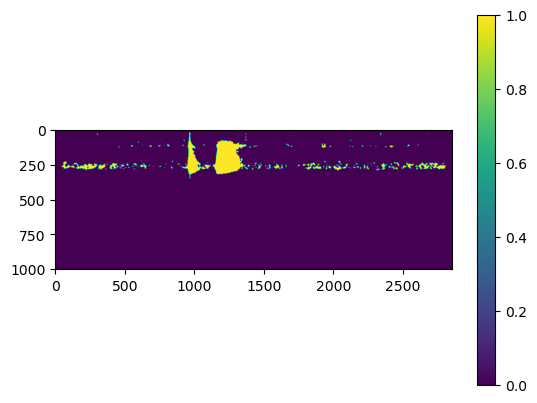

29101.88679245283


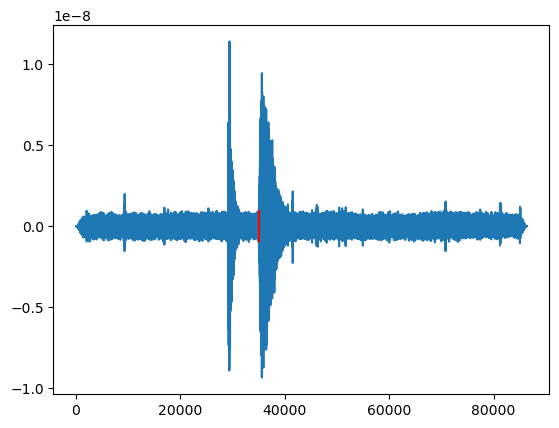

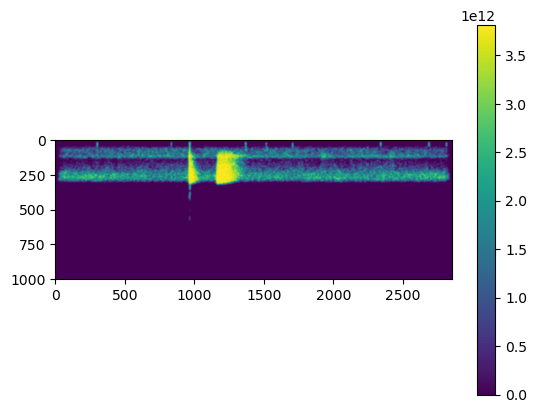

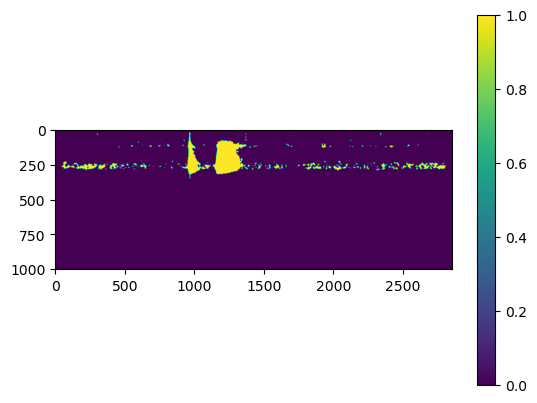

35109.43396226415


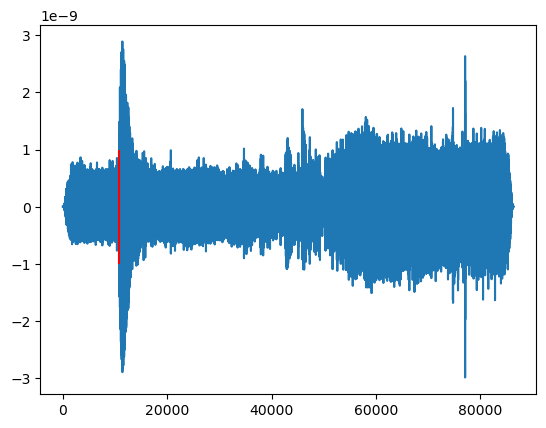

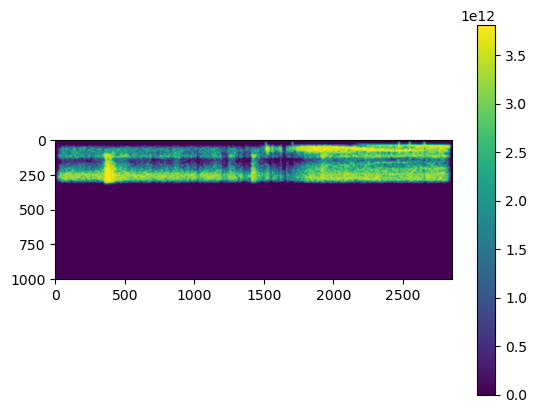

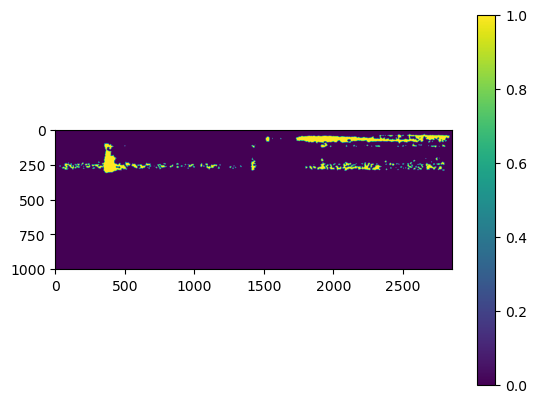

10807.547169811322


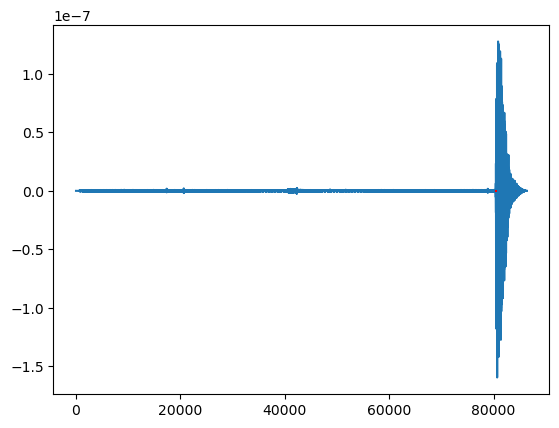

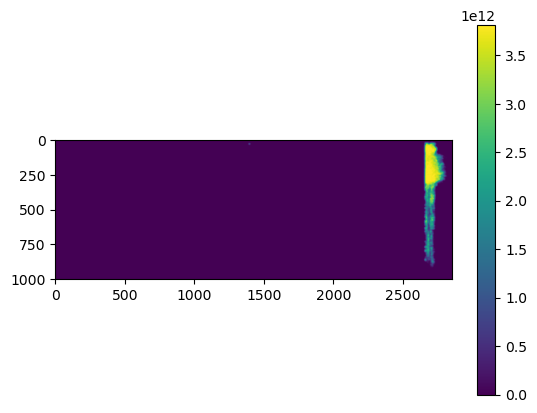

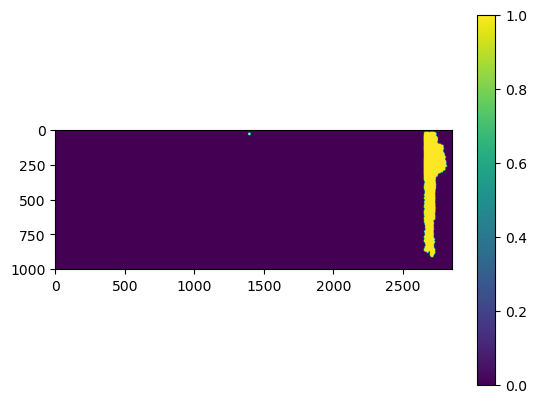

80392.45283018867


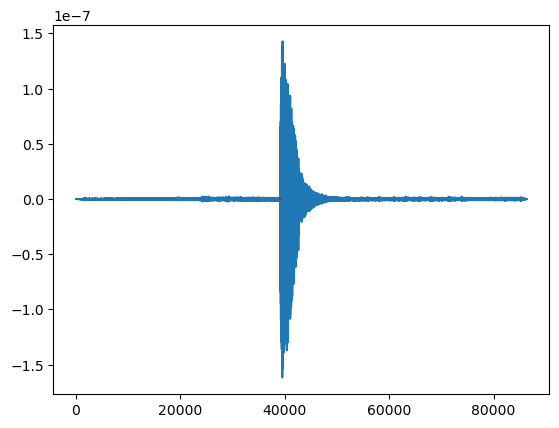

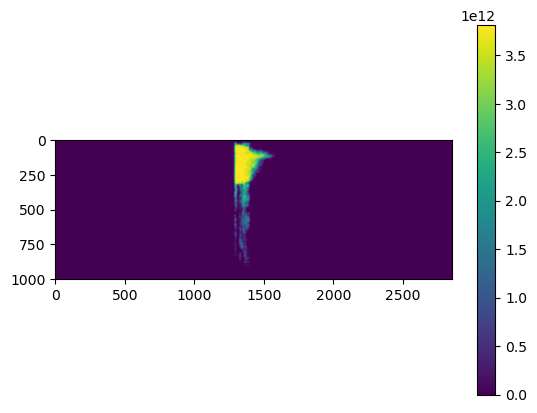

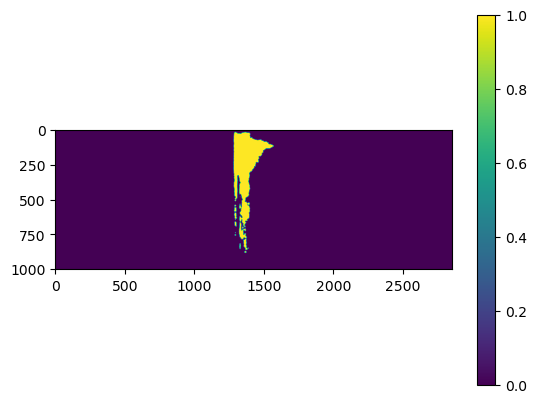

39064.15094339623


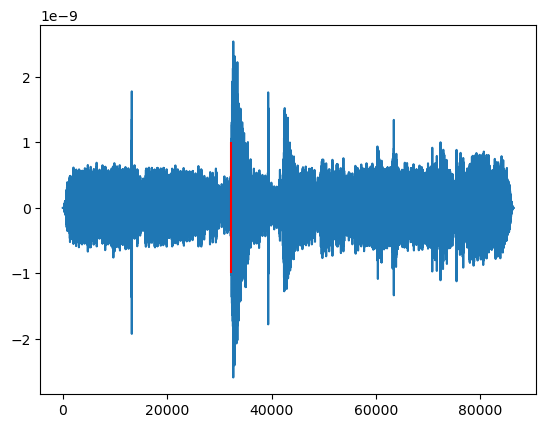

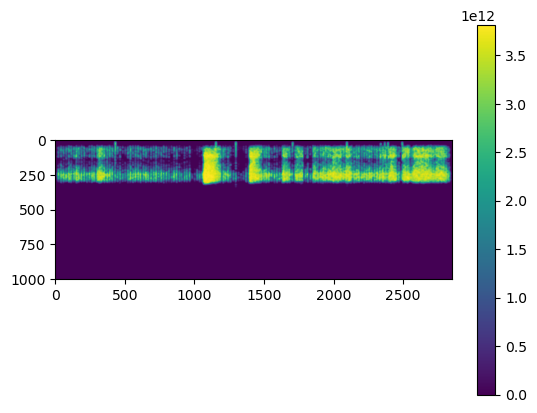

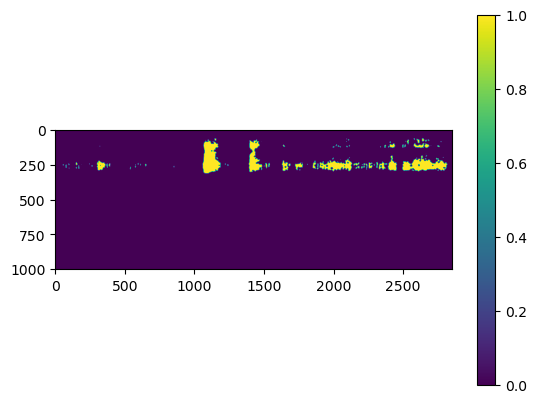

32211.32075471698


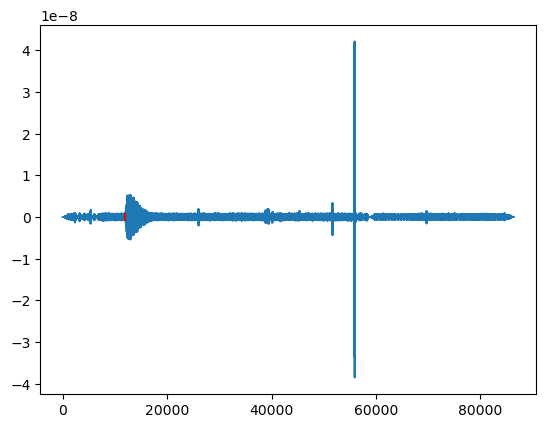

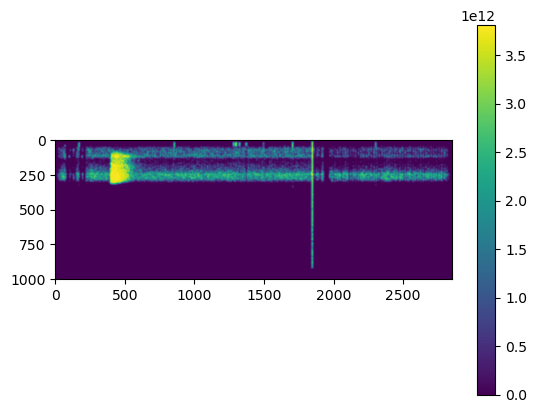

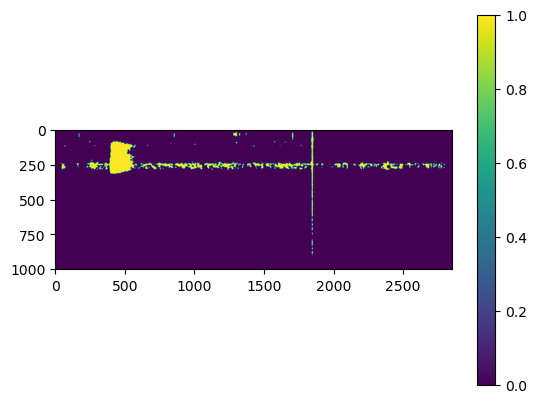

11954.716981132075


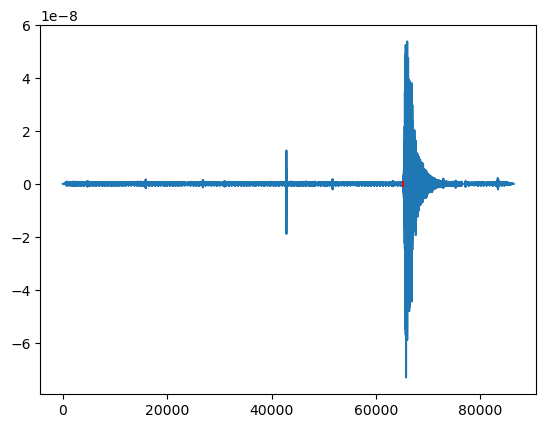

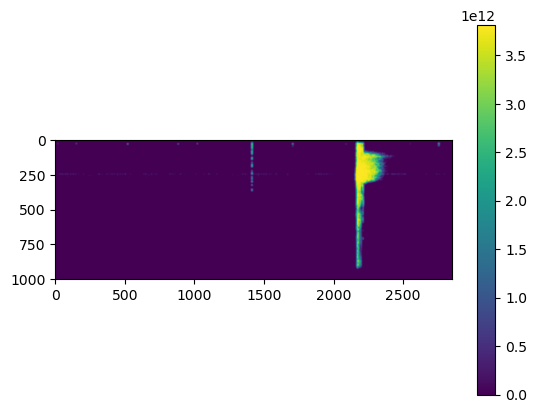

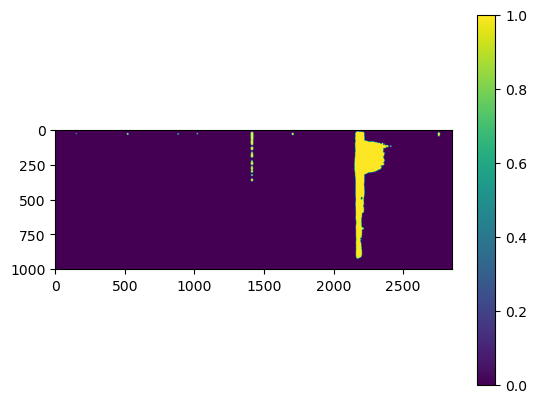

65267.92452830189


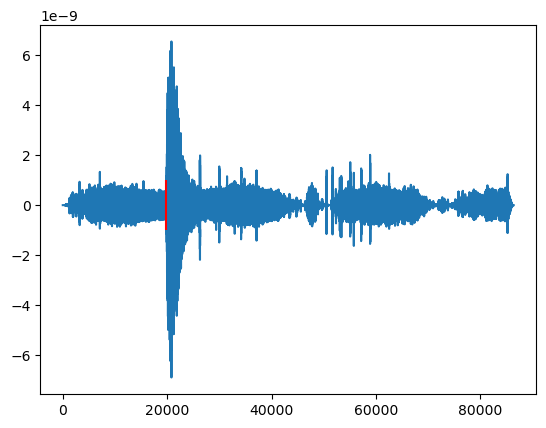

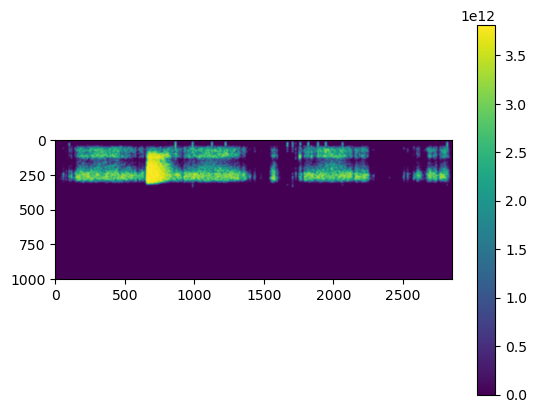

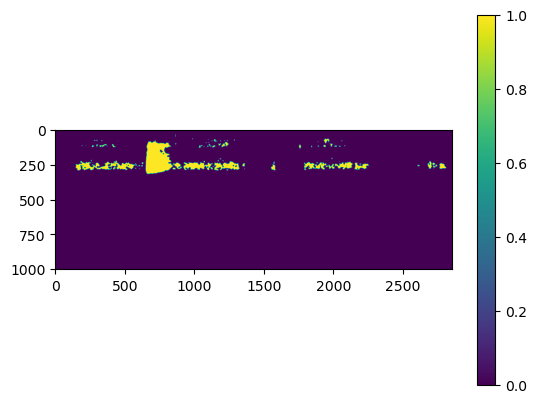

19803.77358490566


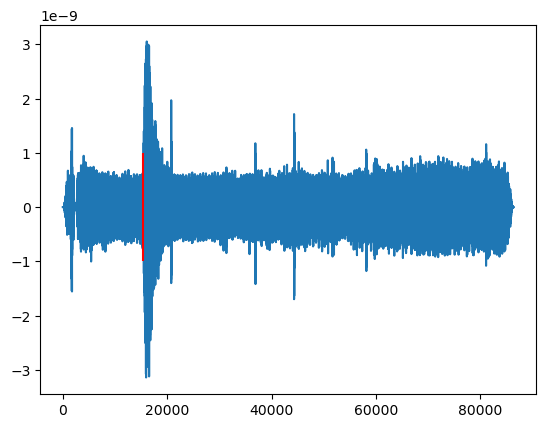

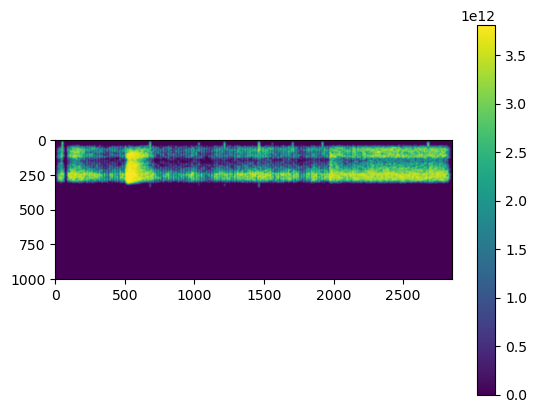

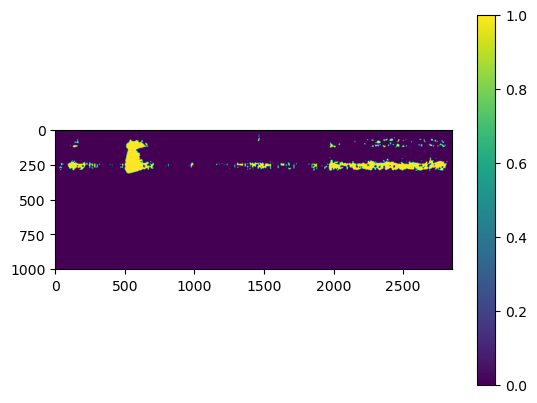

15426.415094339623


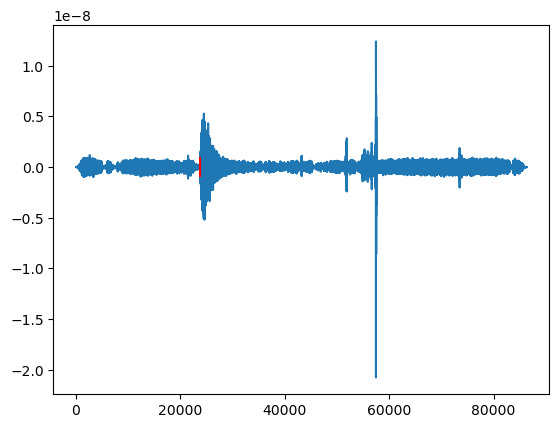

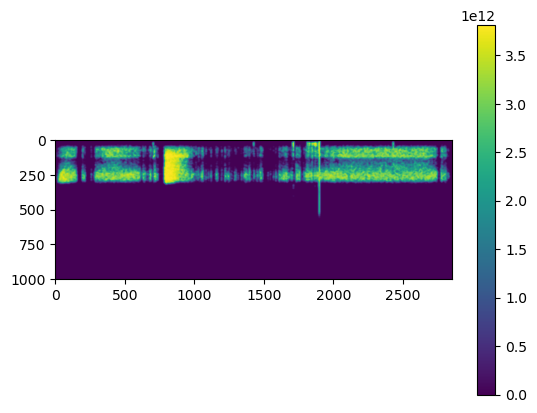

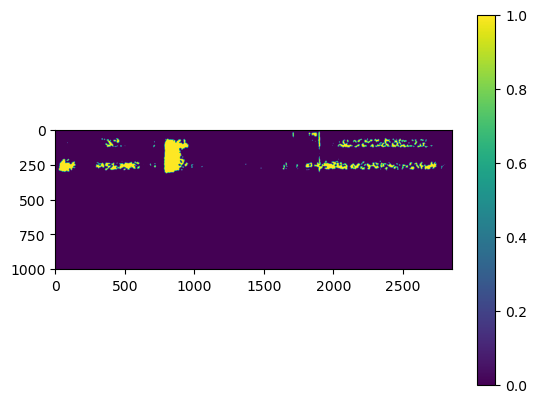

23698.11320754717


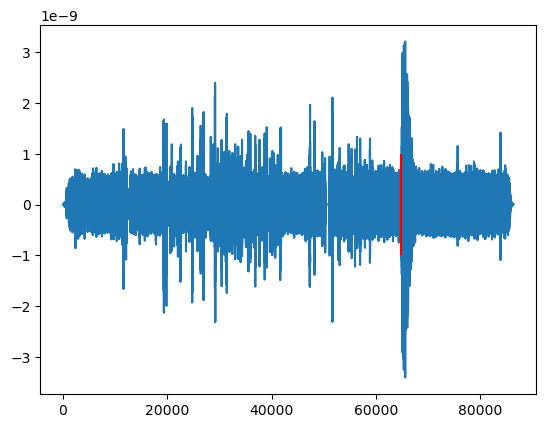

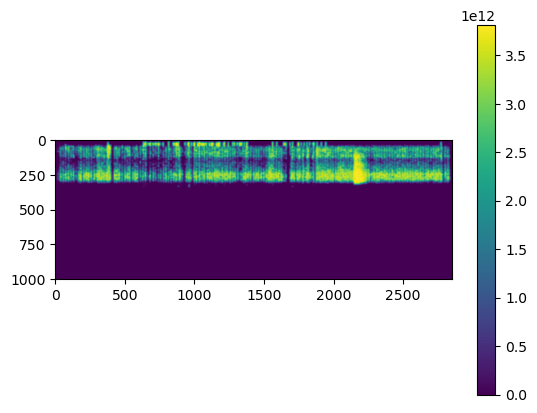

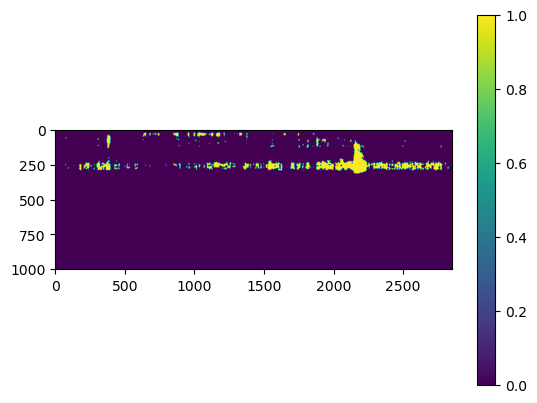

64784.90566037736


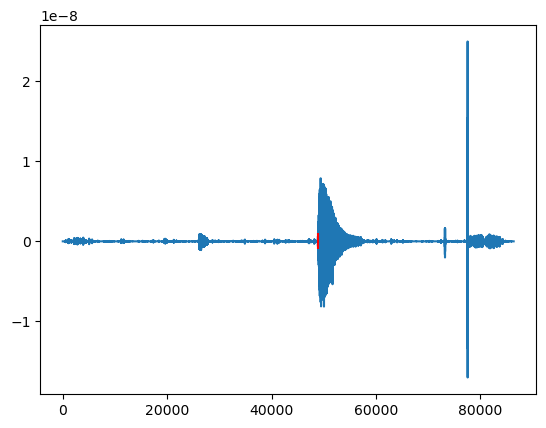

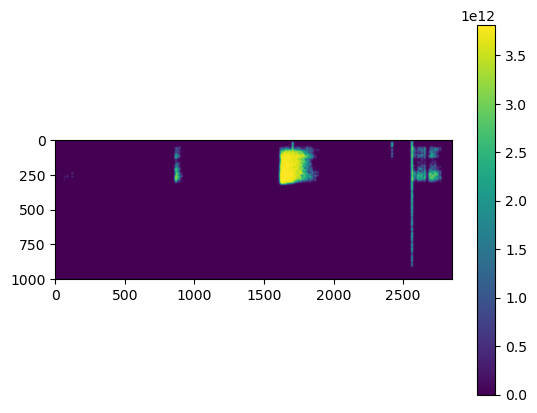

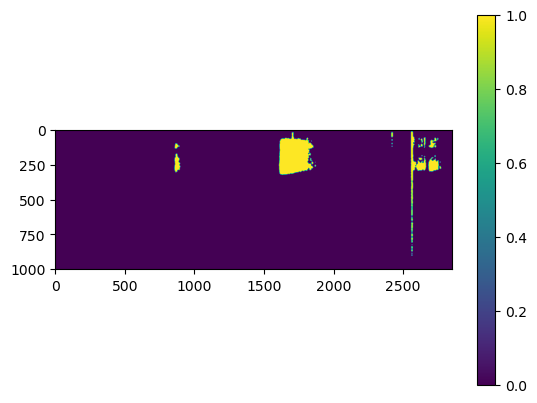

48905.660377358494


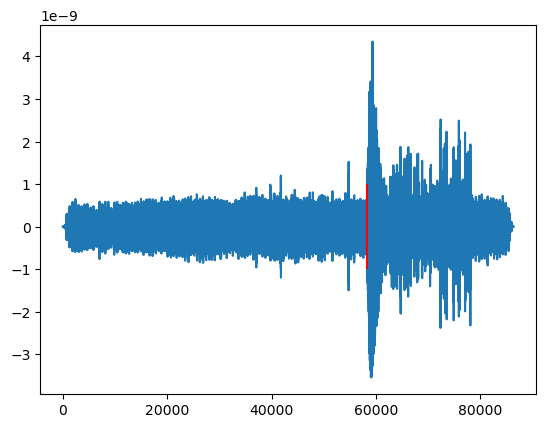

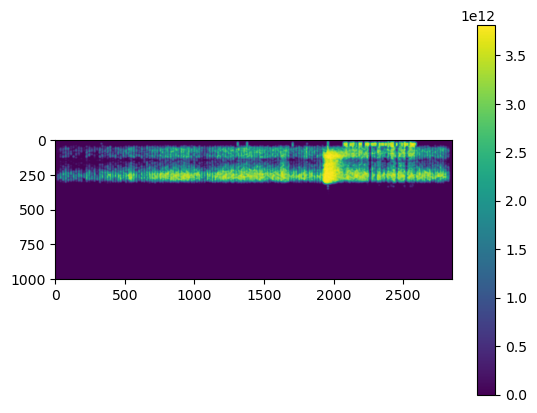

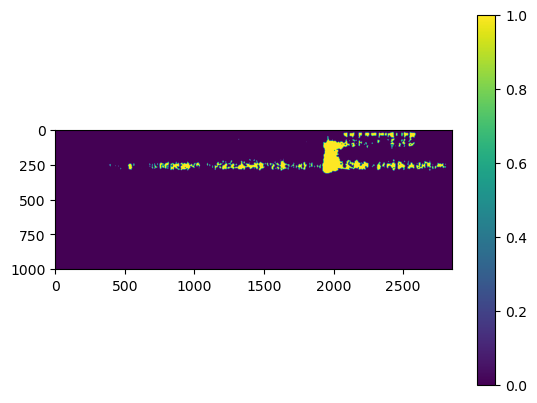

58264.15094339623


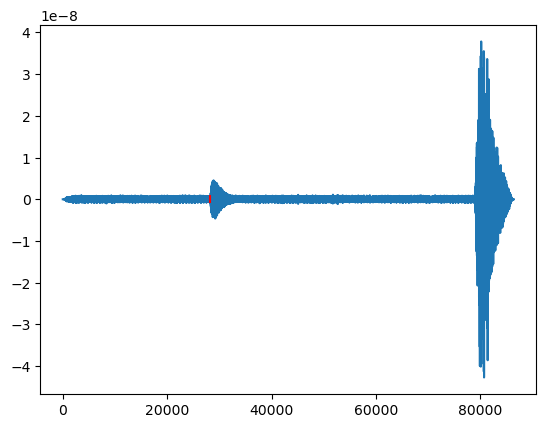

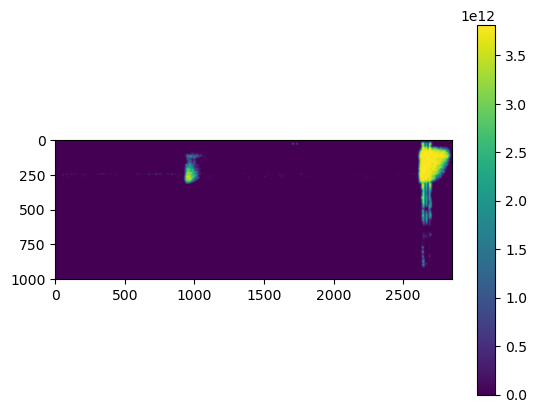

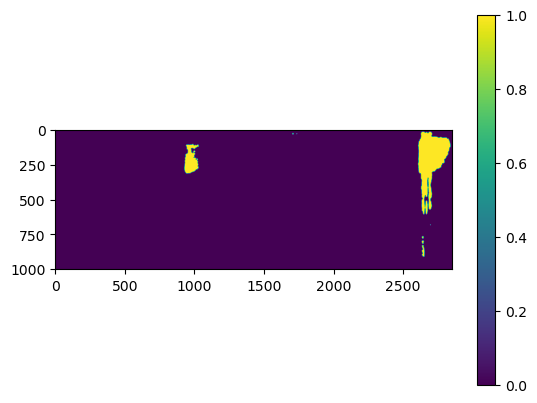

28196.22641509434


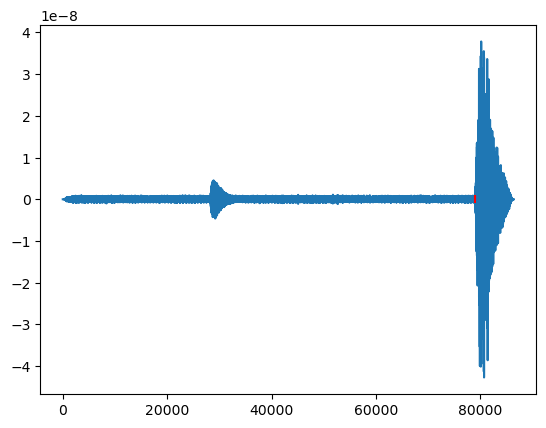

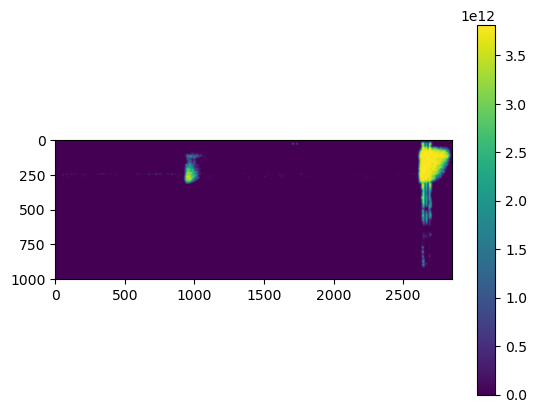

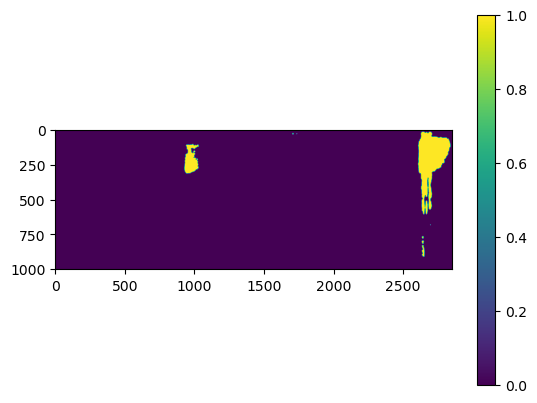

78973.58490566038


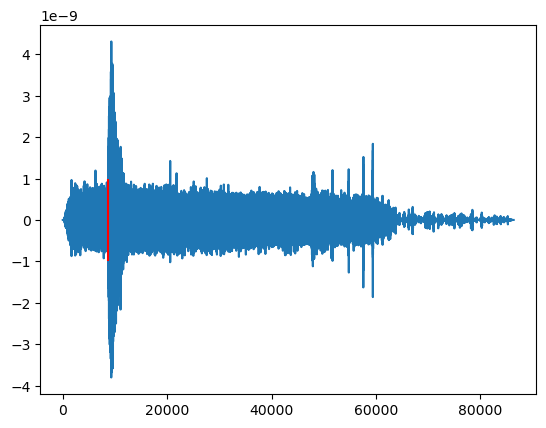

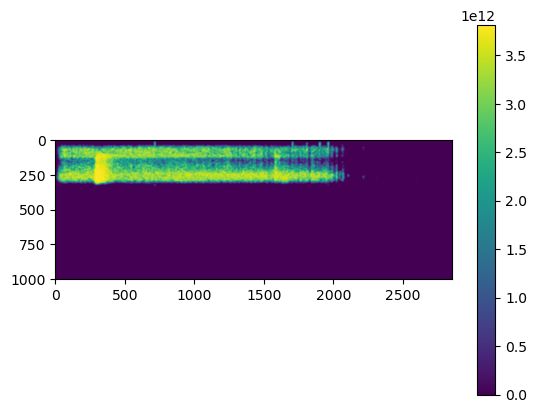

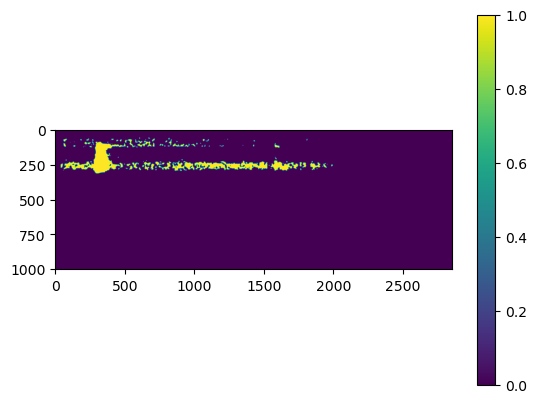

8573.584905660377


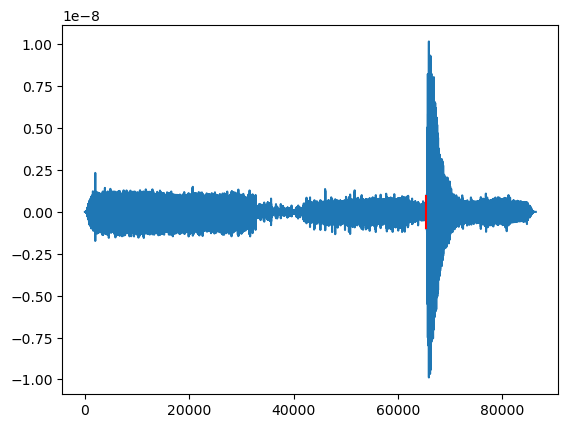

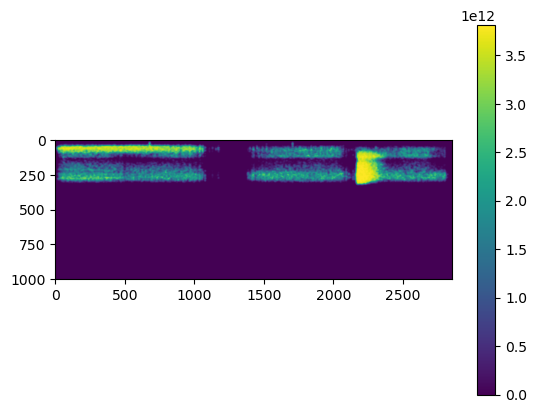

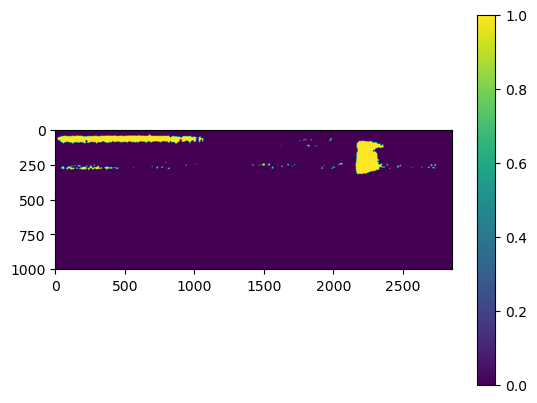

65267.92452830189


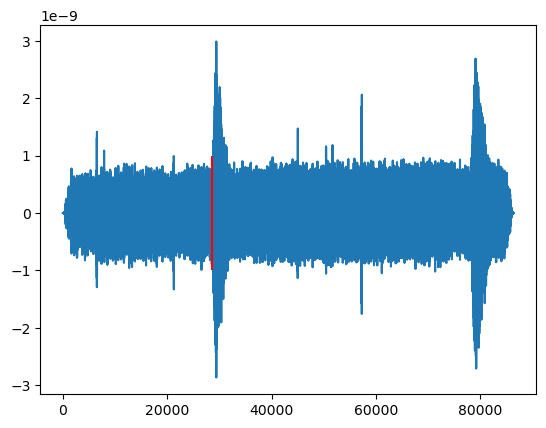

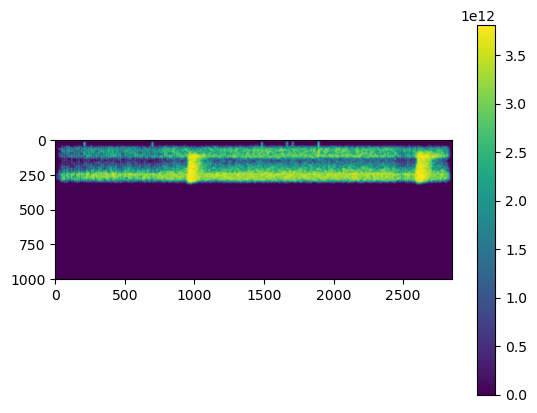

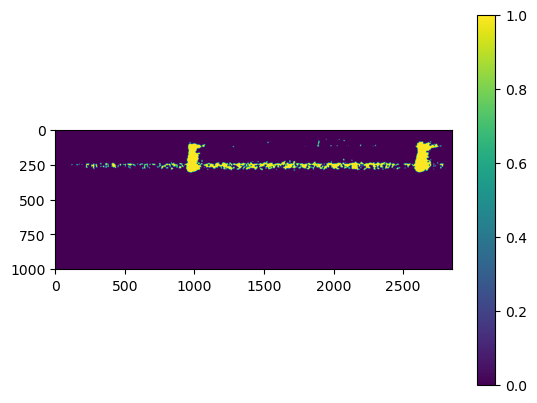

28679.245283018867


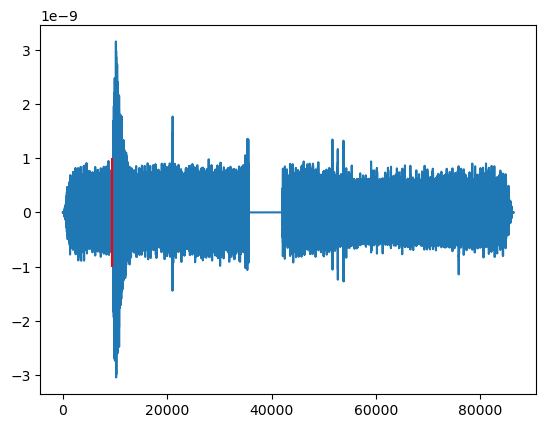

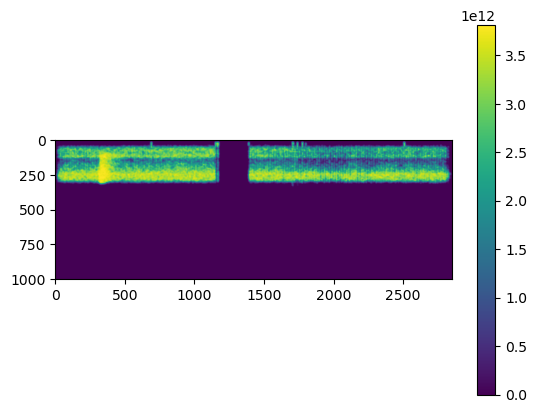

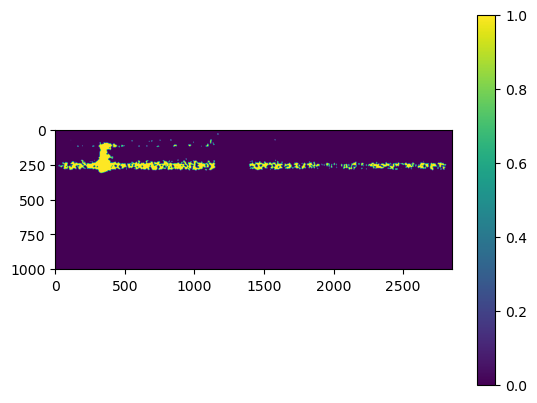

9479.245283018869


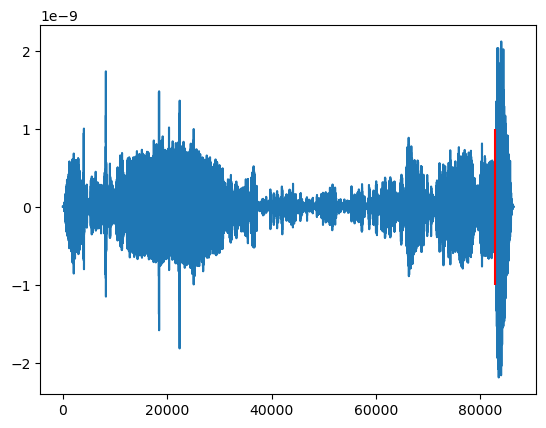

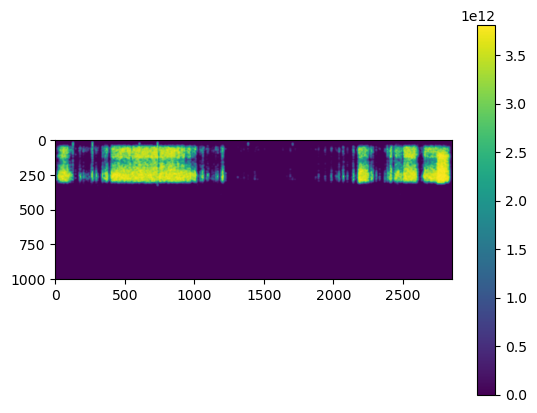

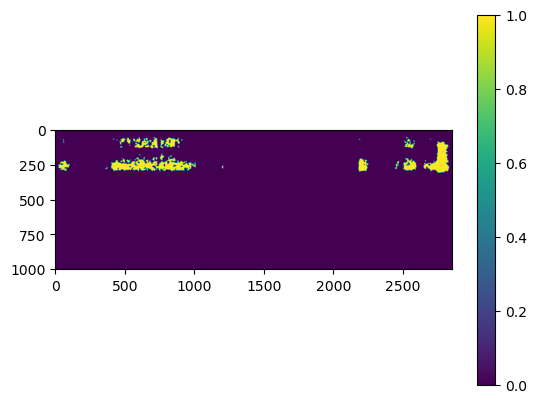

82867.92452830188


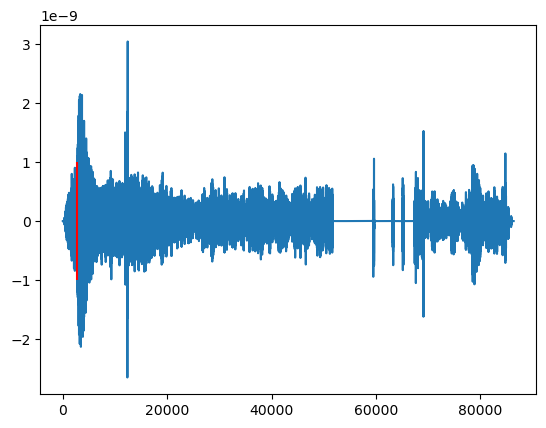

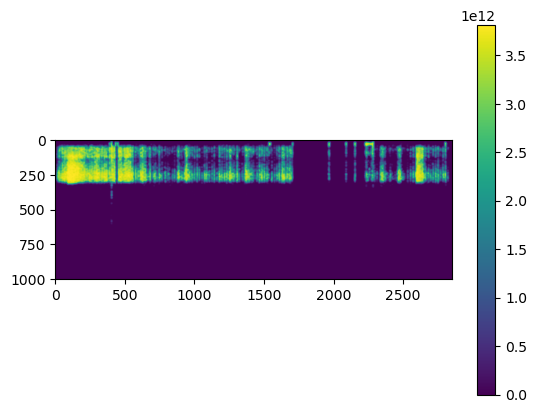

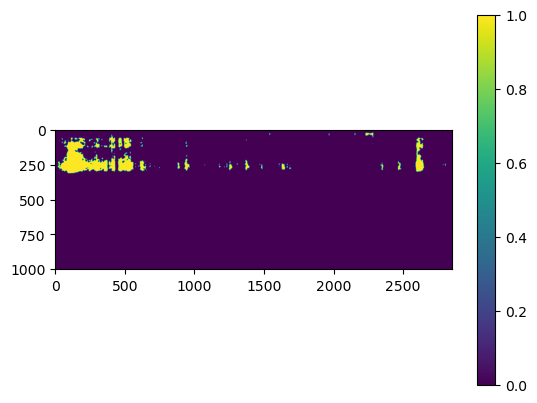

2626.4150943396226


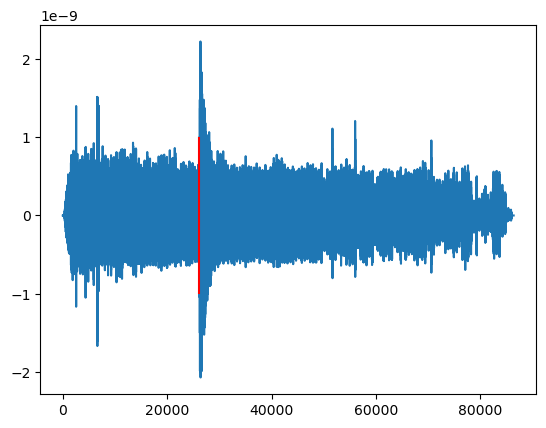

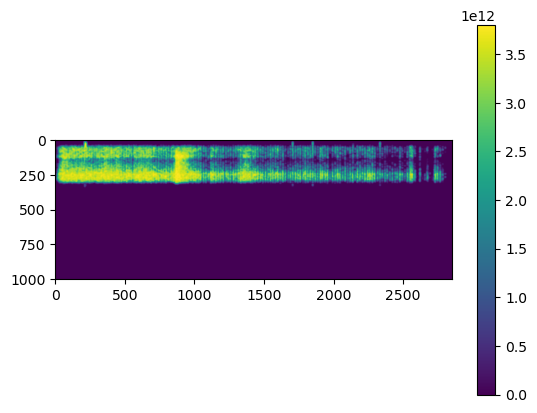

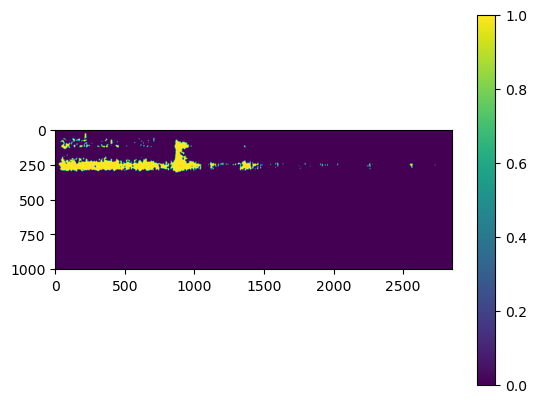

26113.20754716981


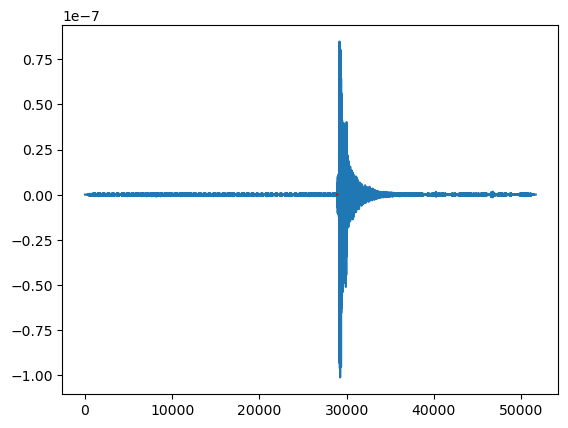

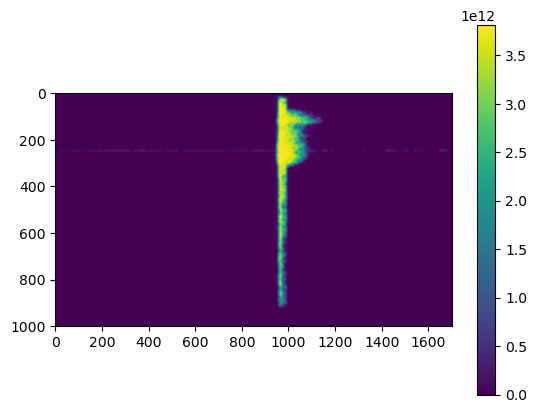

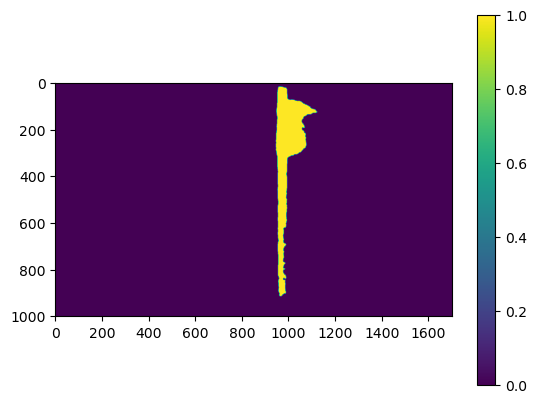

28860.377358490565


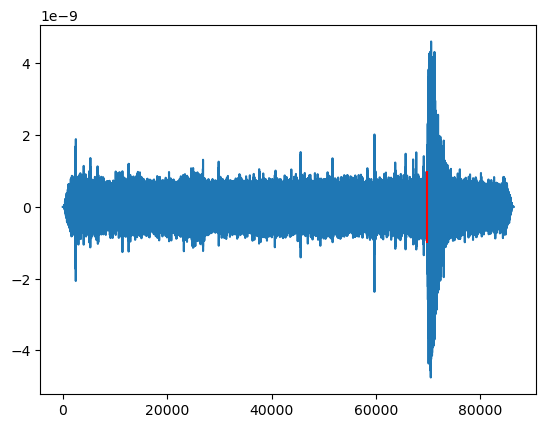

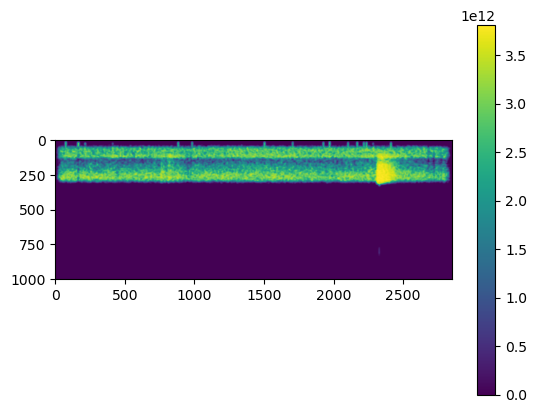

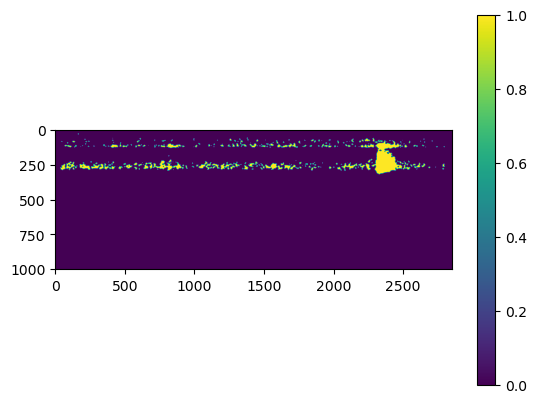

69766.03773584905


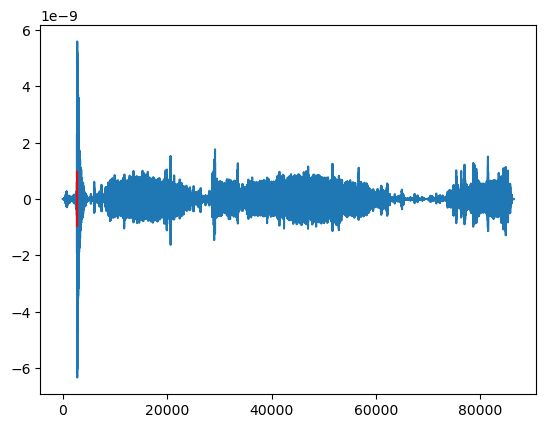

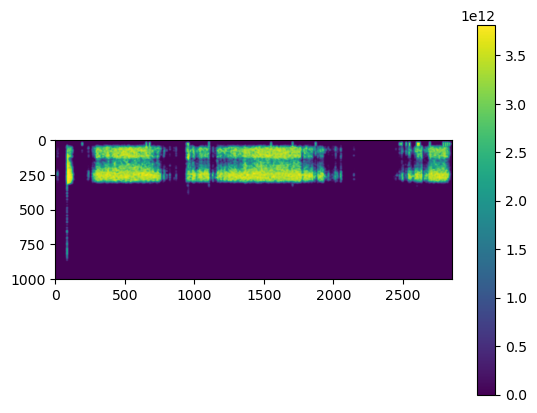

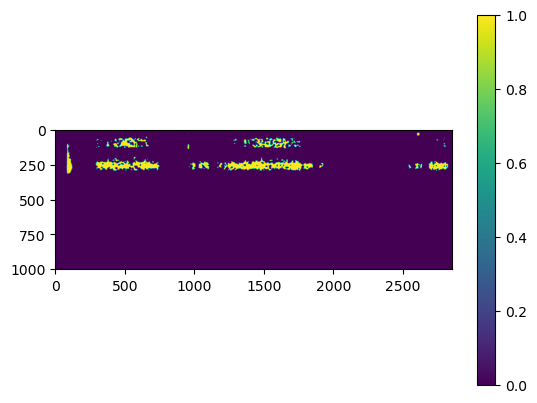

2626.4150943396226


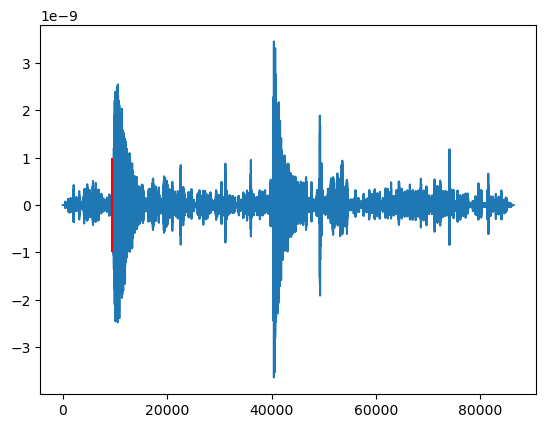

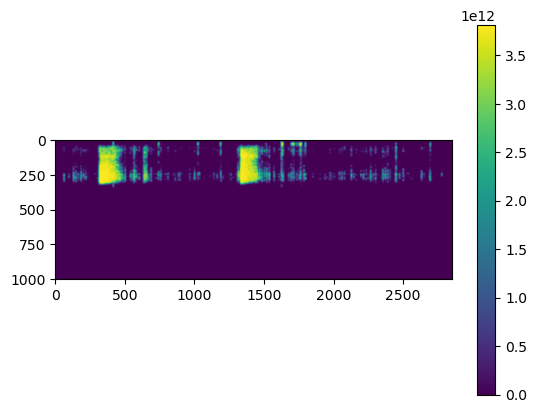

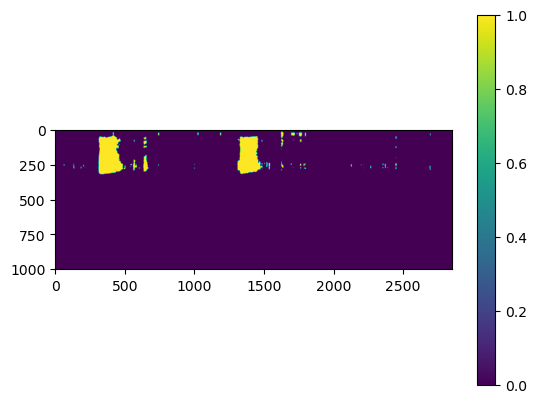

9479.245283018869


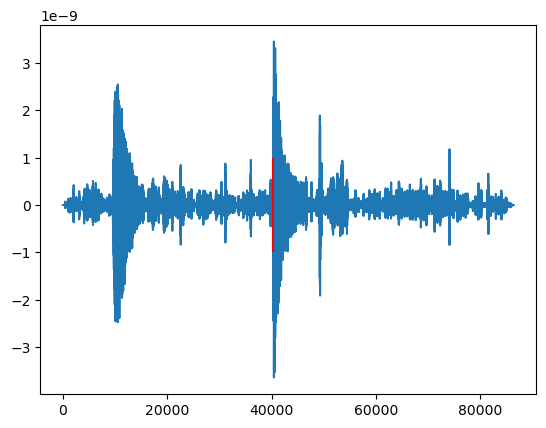

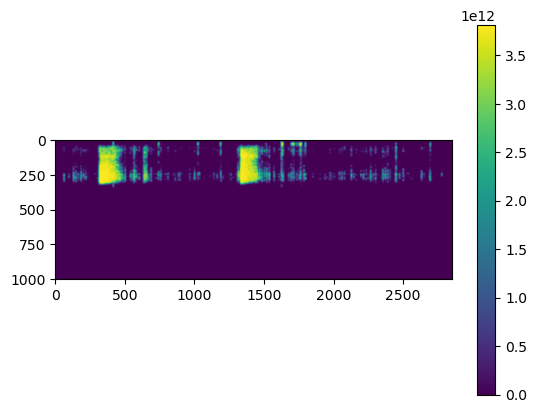

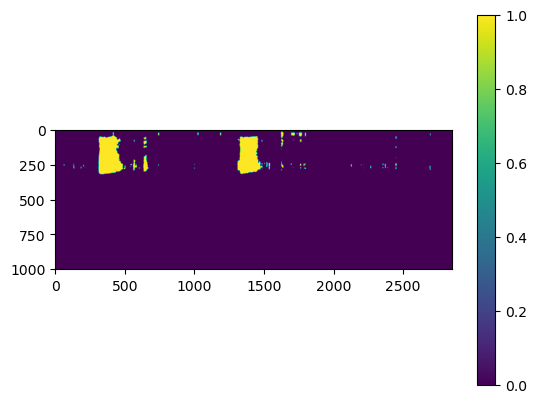

40211.32075471698


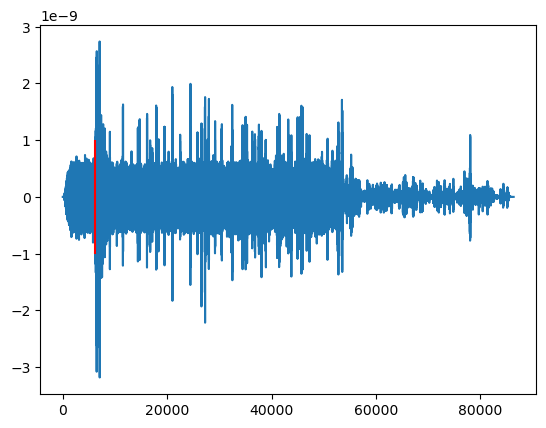

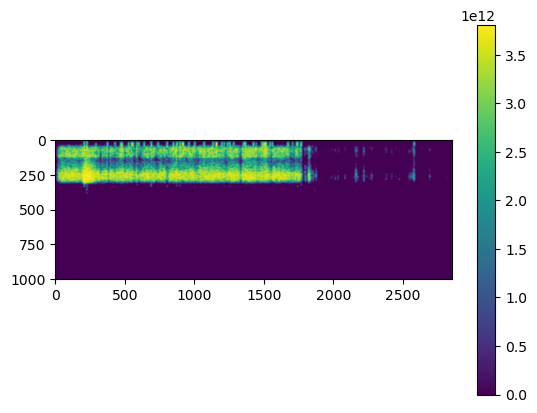

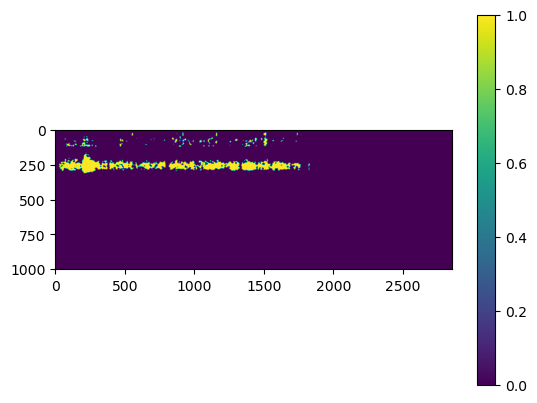

6128.301886792453


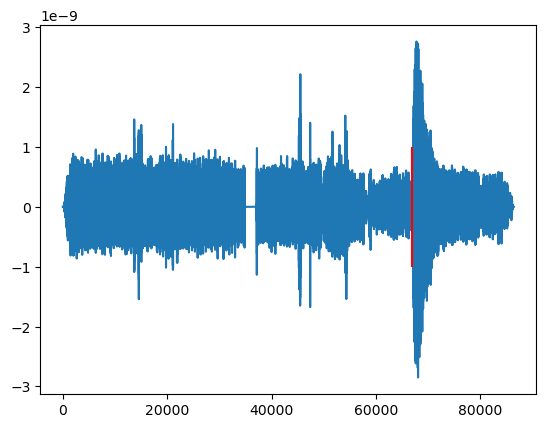

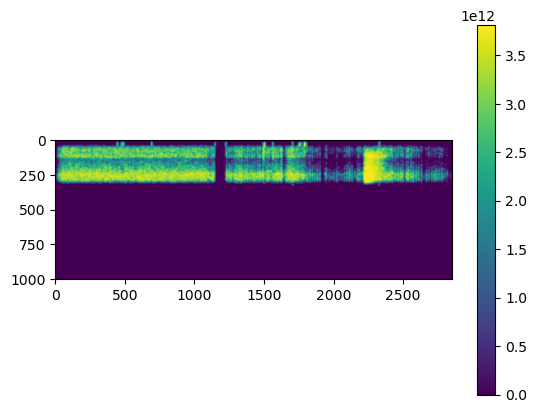

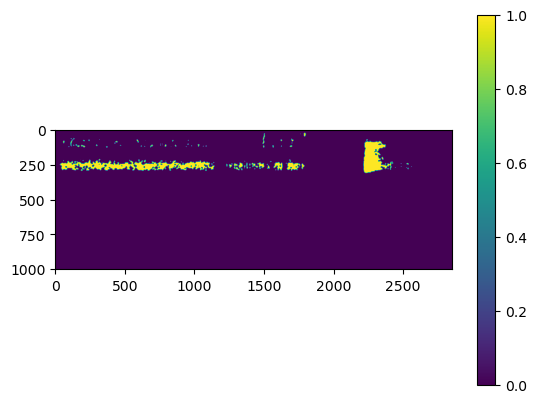

66958.49056603774


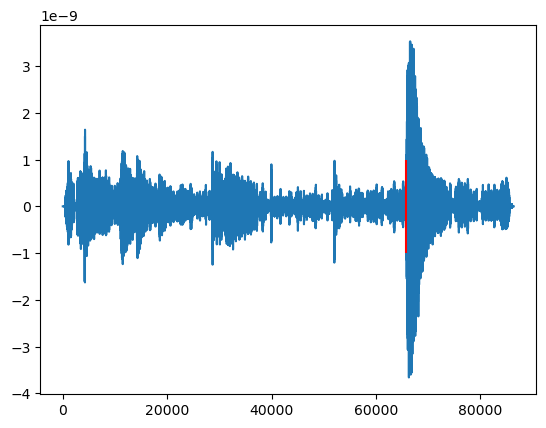

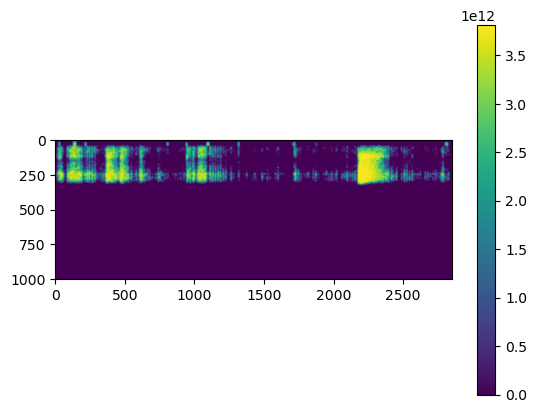

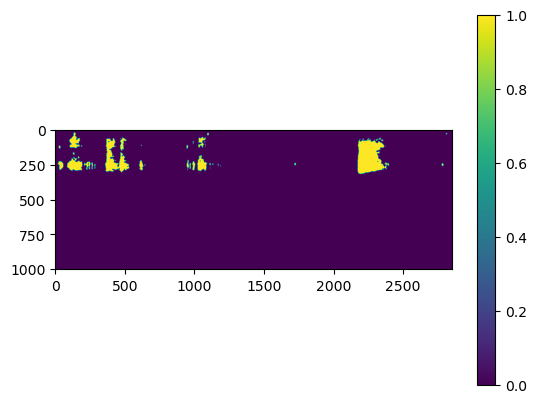

65690.56603773584


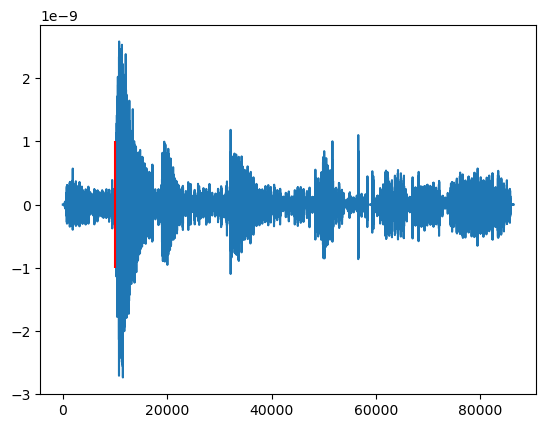

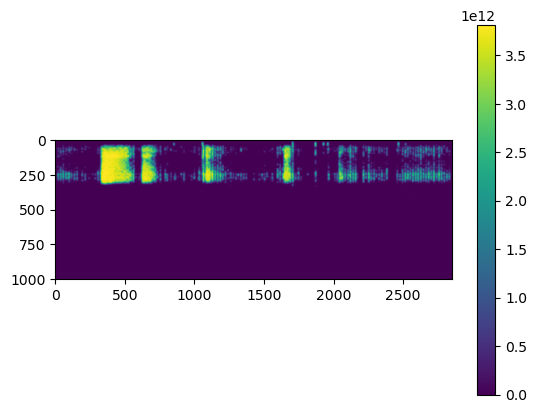

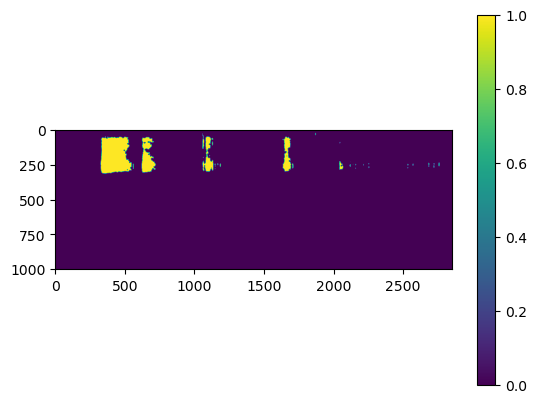

9962.264150943396


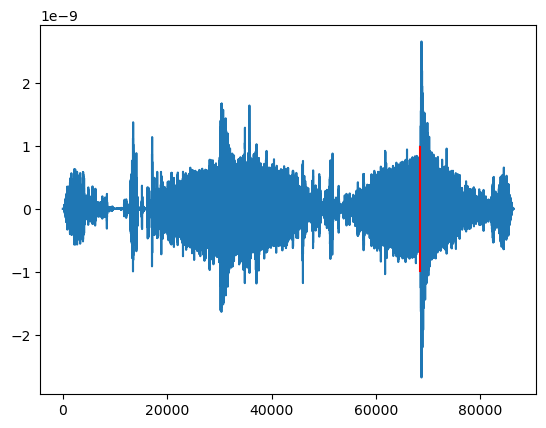

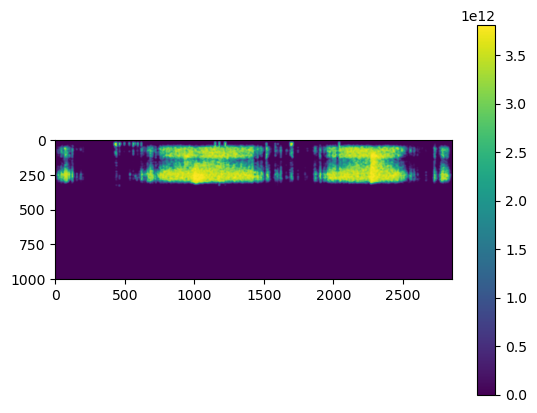

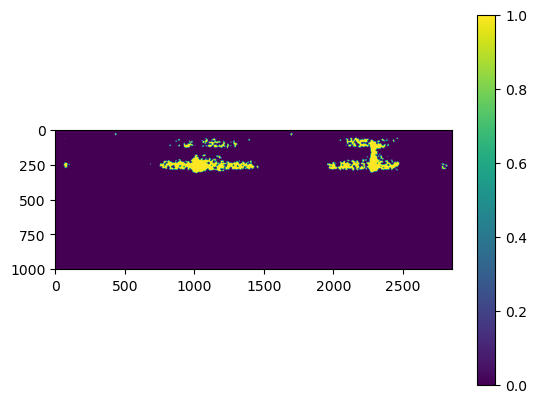

68528.30188679245


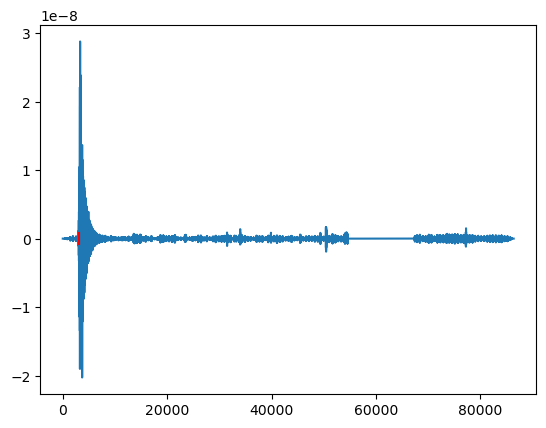

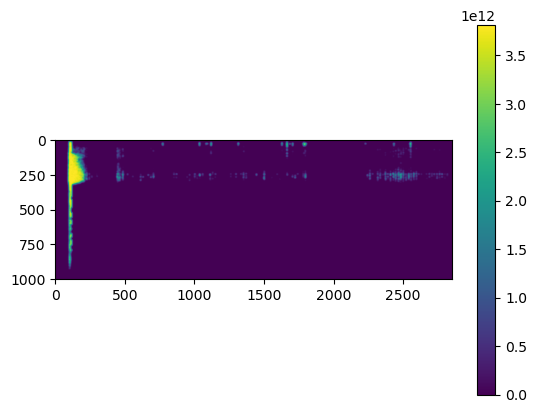

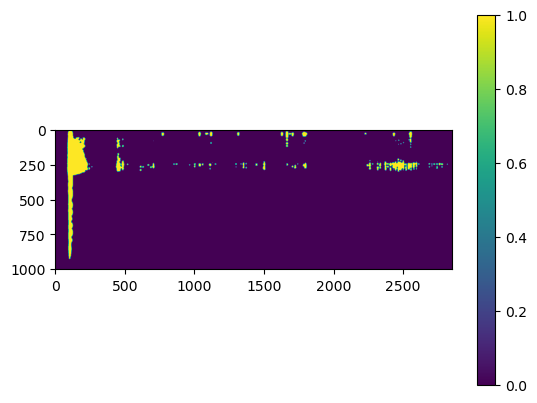

3109.433962264151


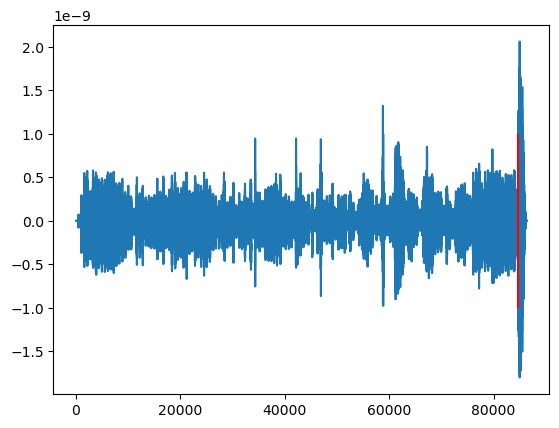

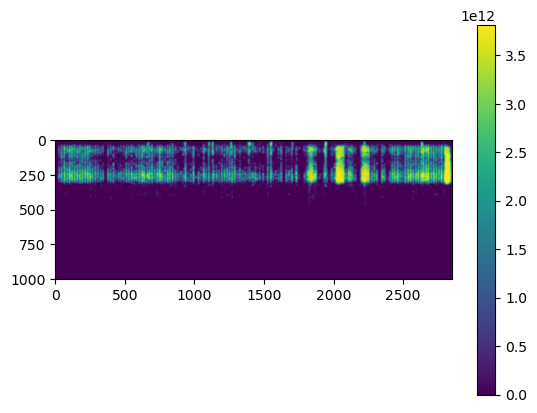

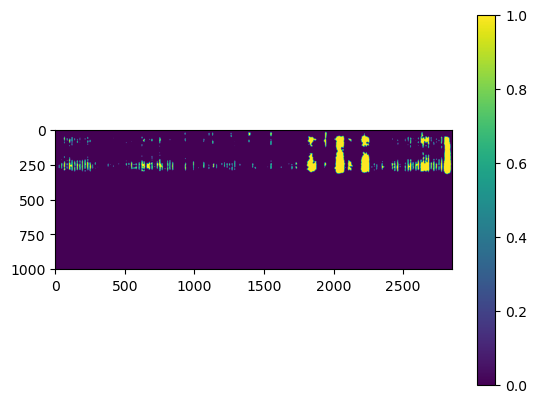

84649.05660377358


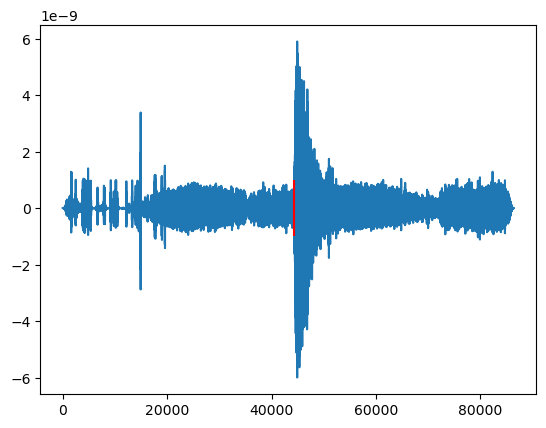

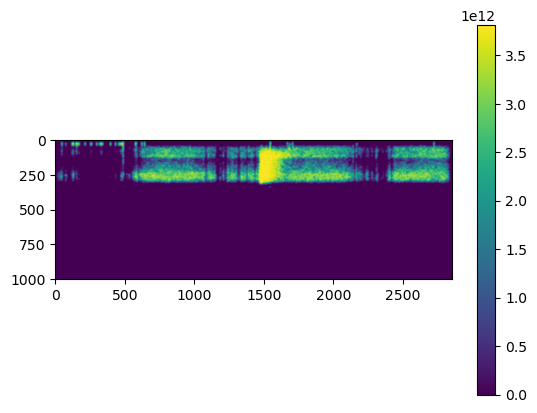

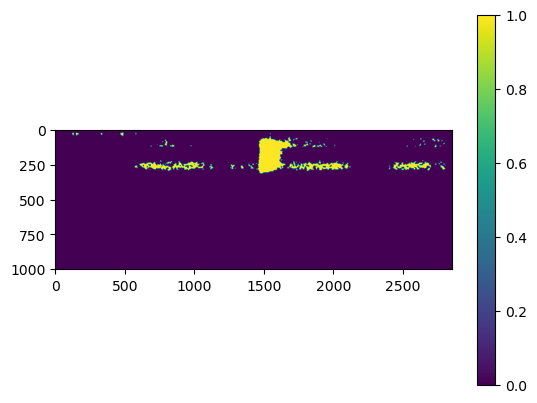

44226.41509433962


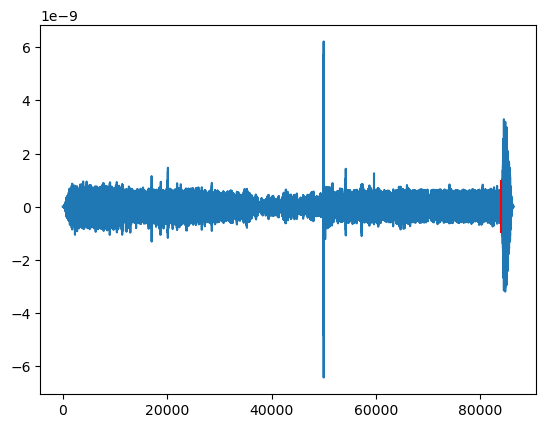

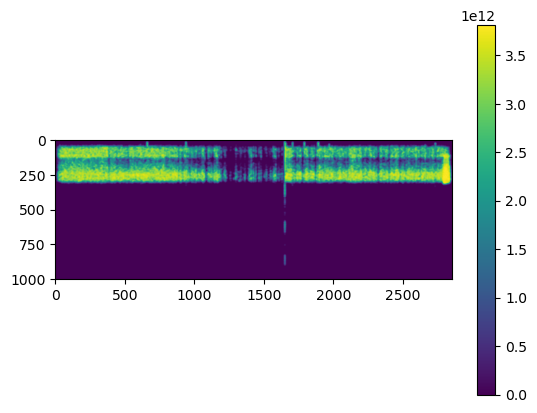

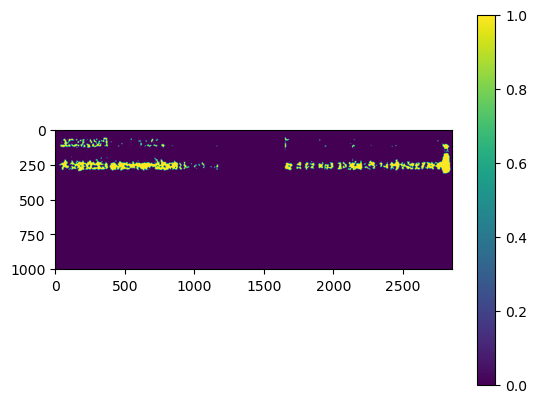

84045.28301886792


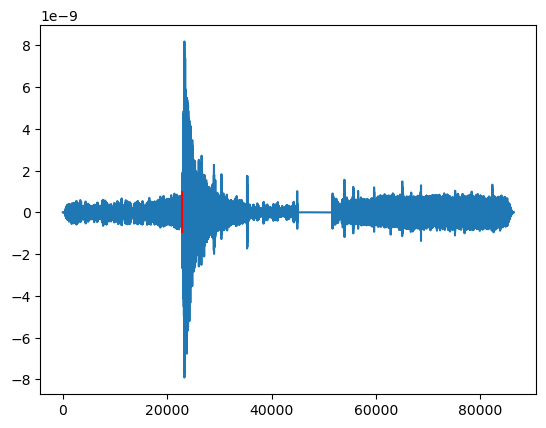

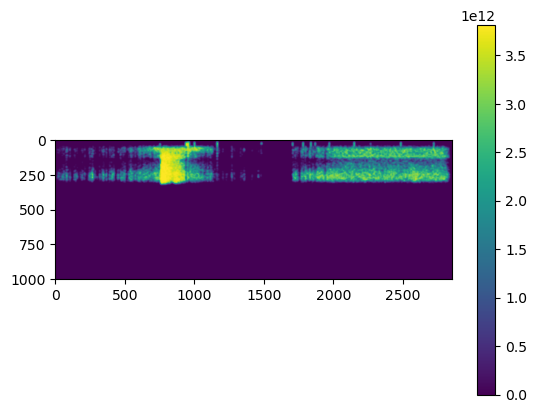

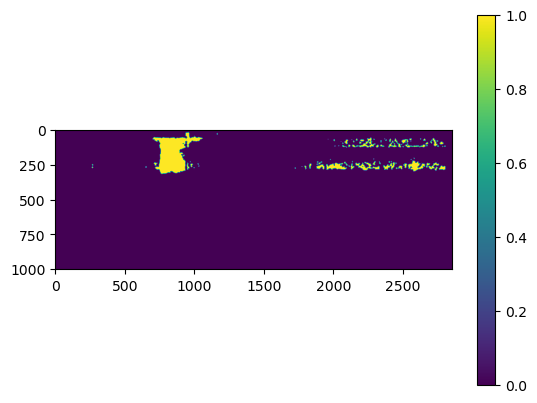

22852.830188679247


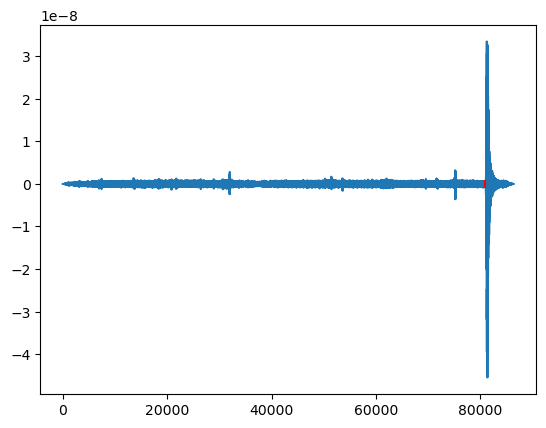

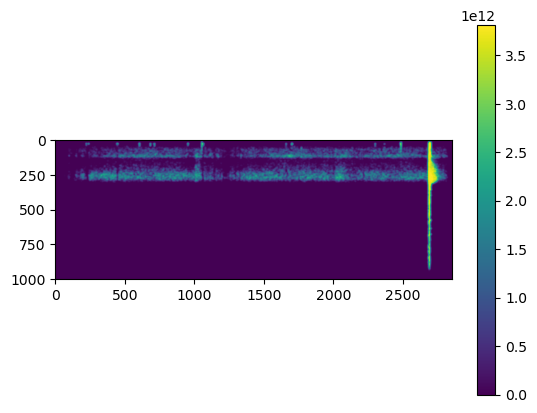

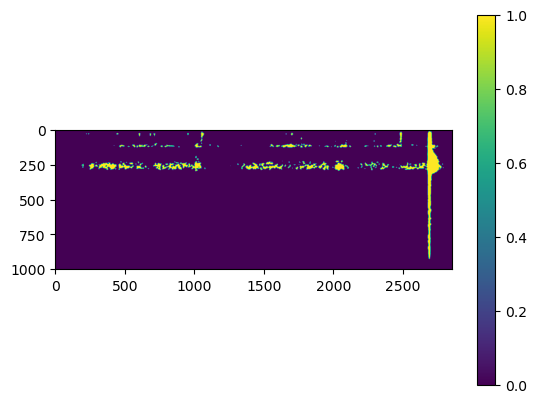

80996.22641509434


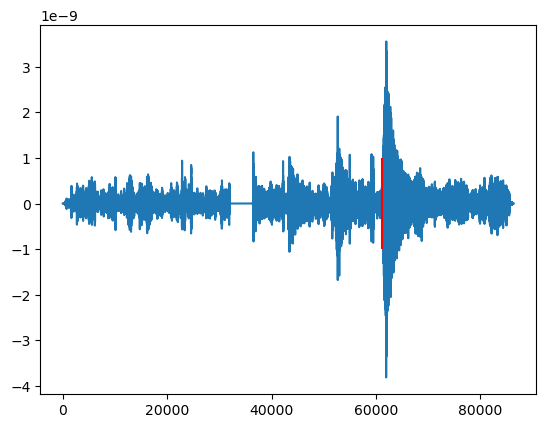

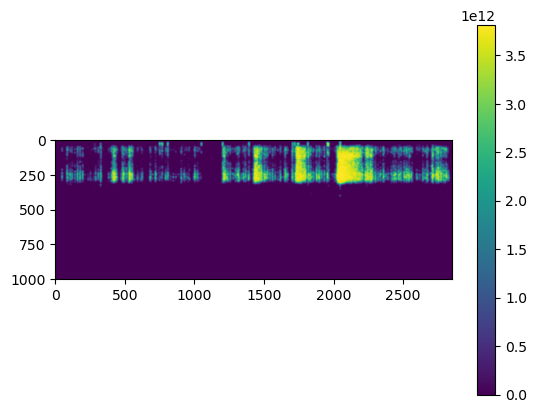

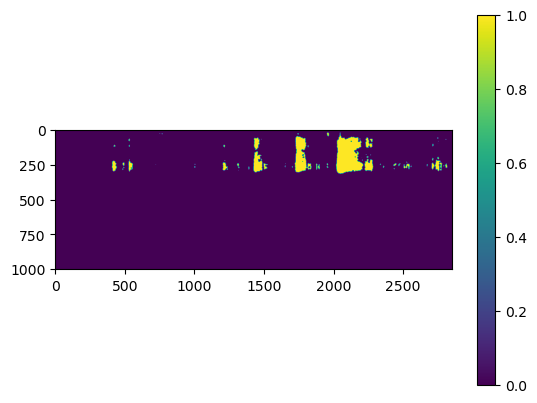

61071.698113207545


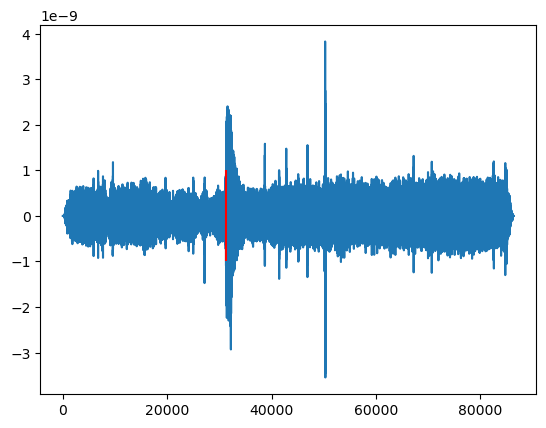

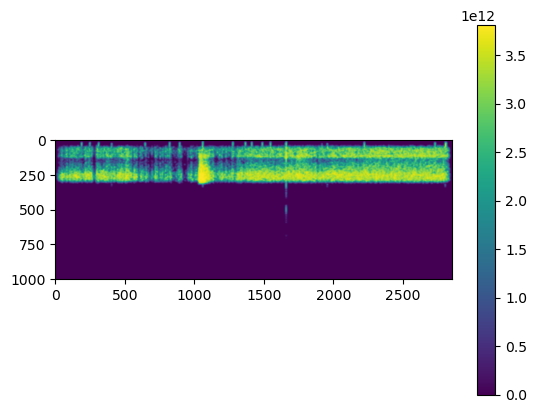

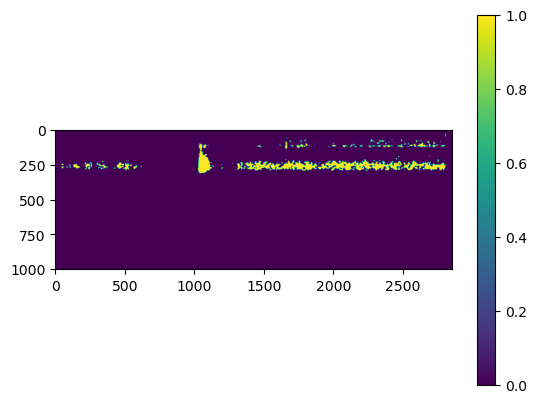

31184.905660377357


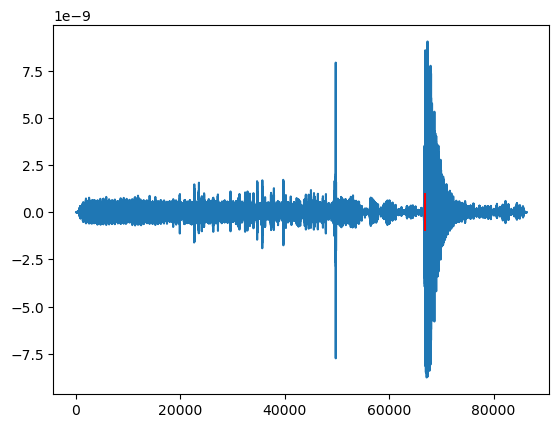

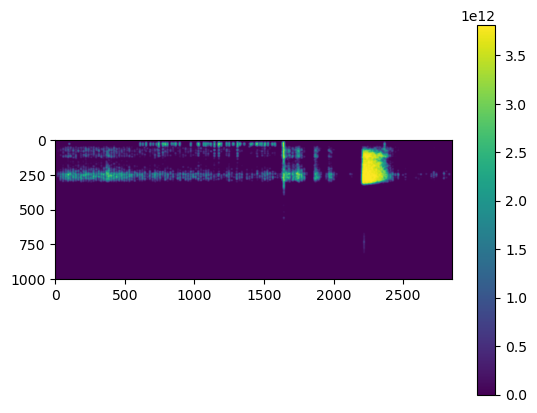

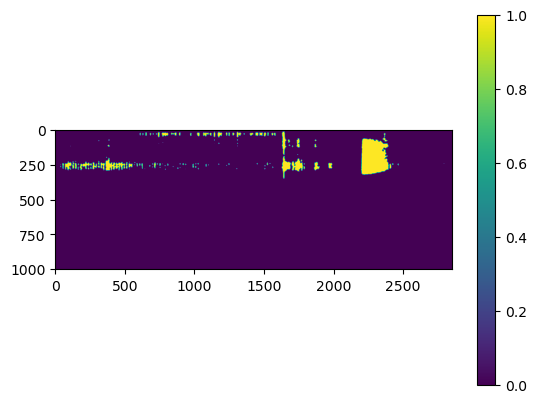

66837.7358490566


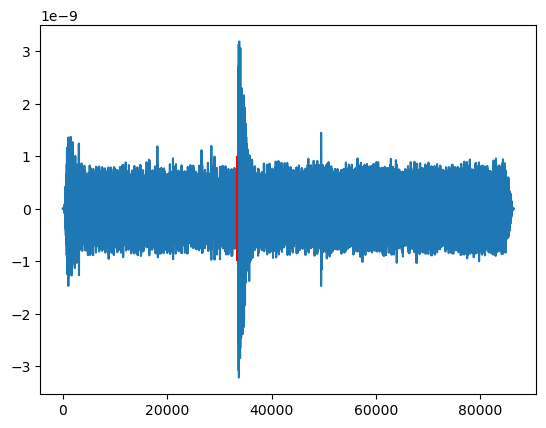

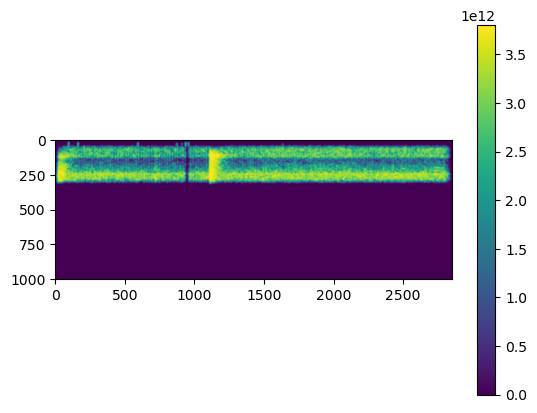

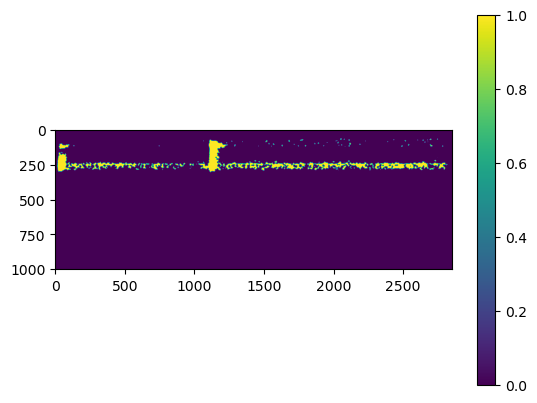

33479.24528301887


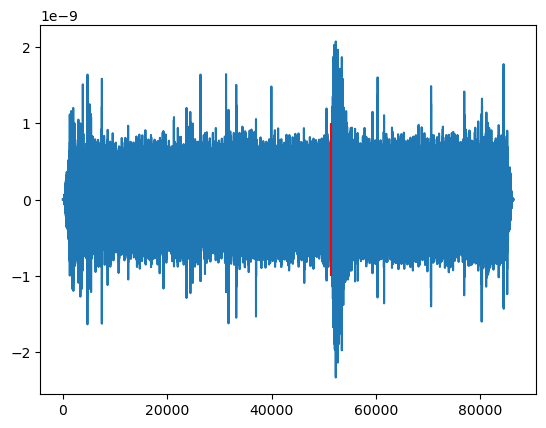

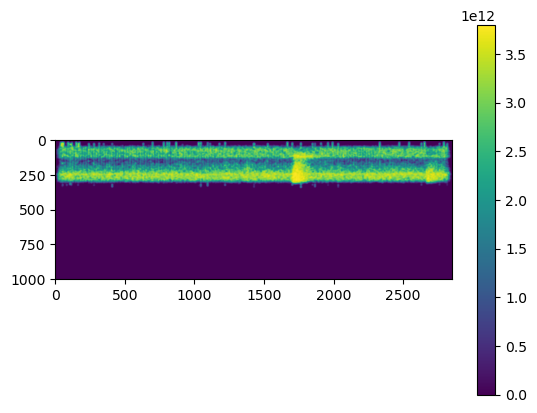

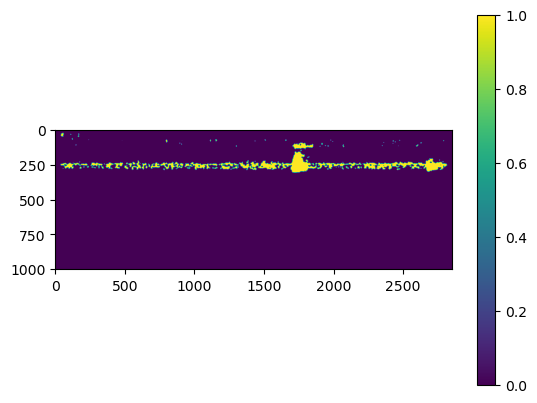

51471.698113207545


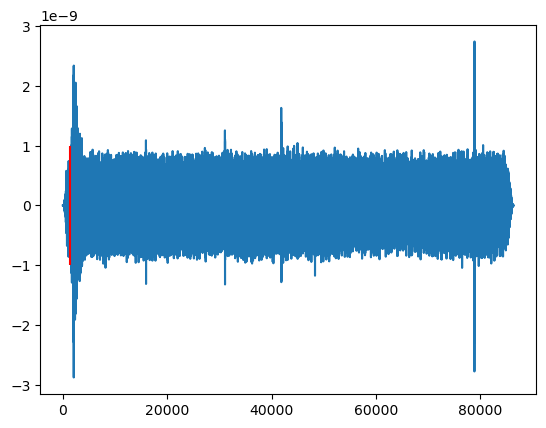

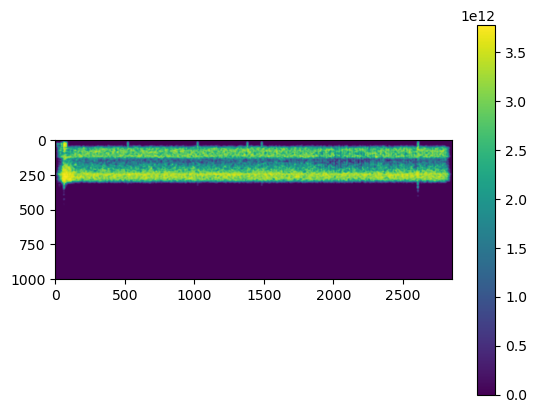

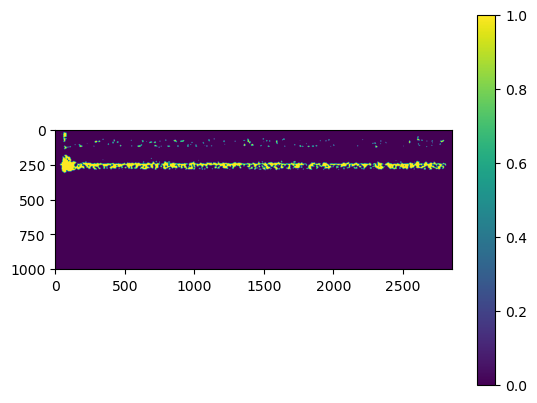

1388.6792452830189


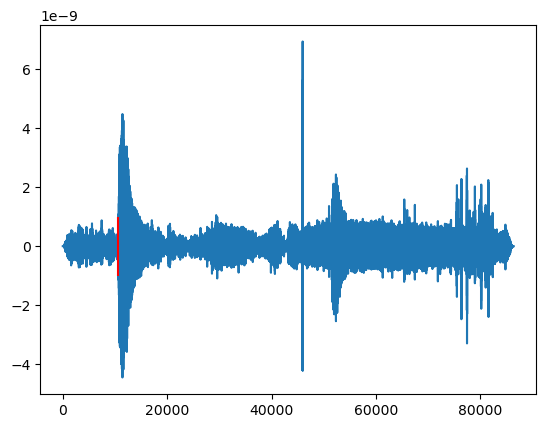

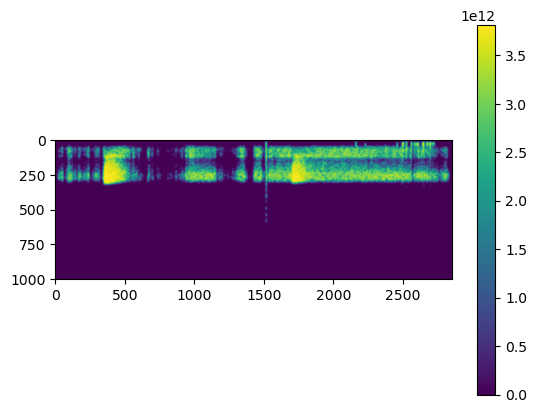

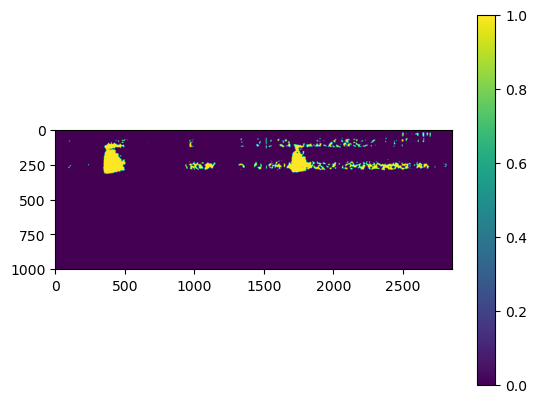

10626.415094339623


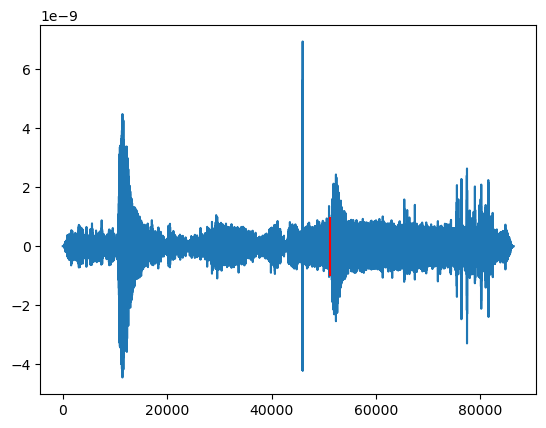

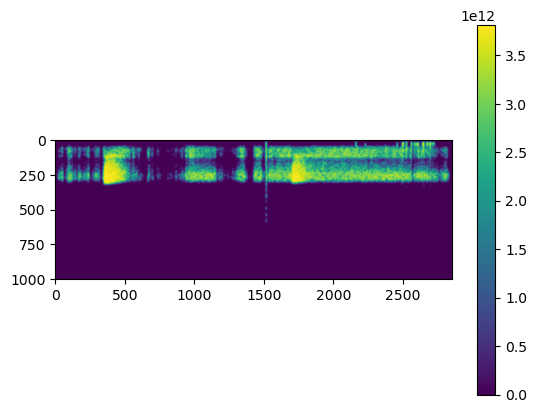

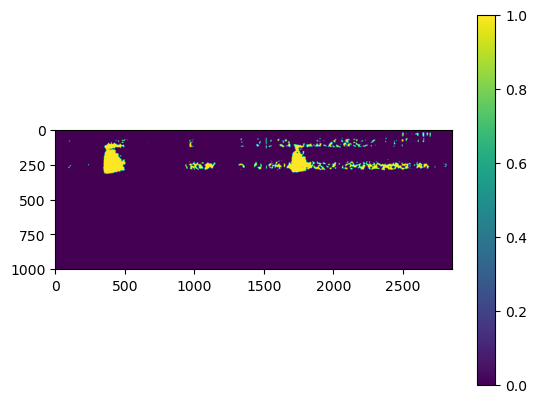

51230.188679245286


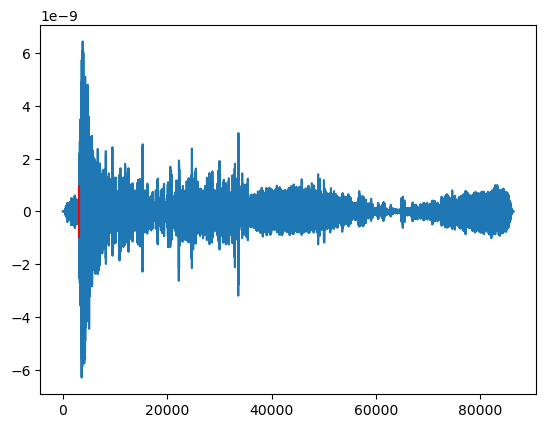

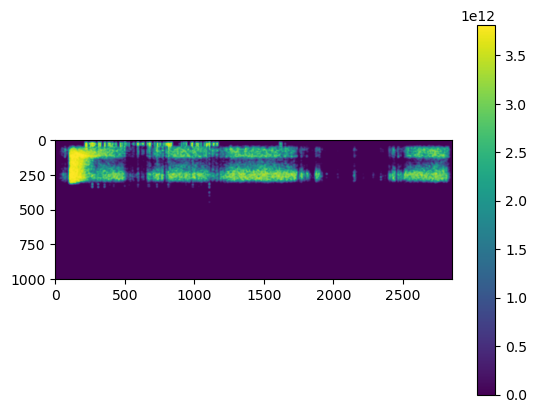

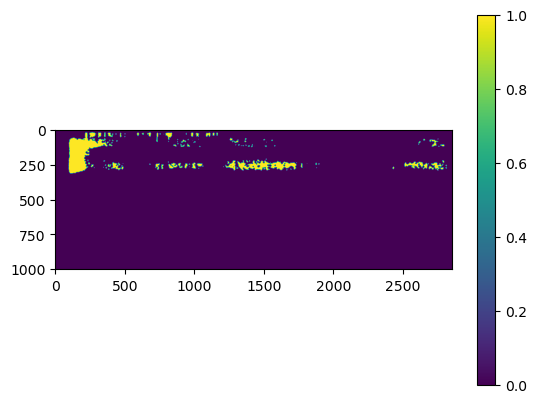

3109.433962264151


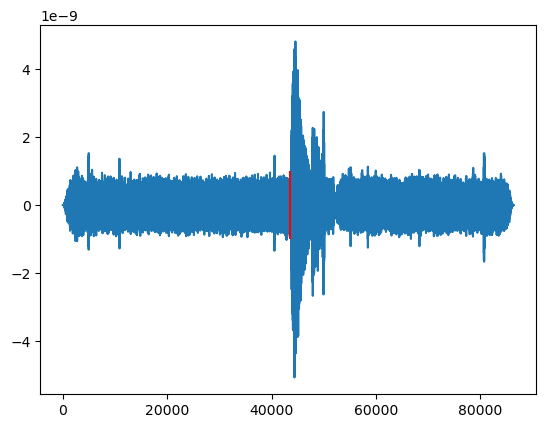

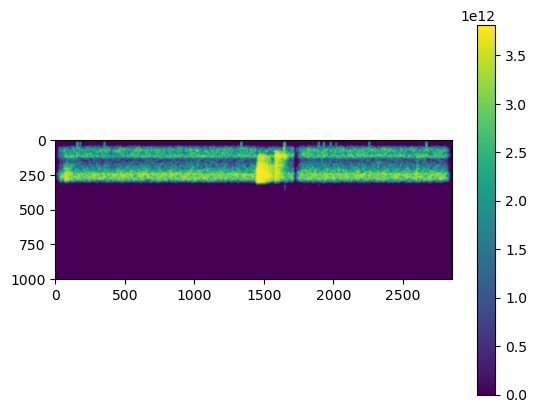

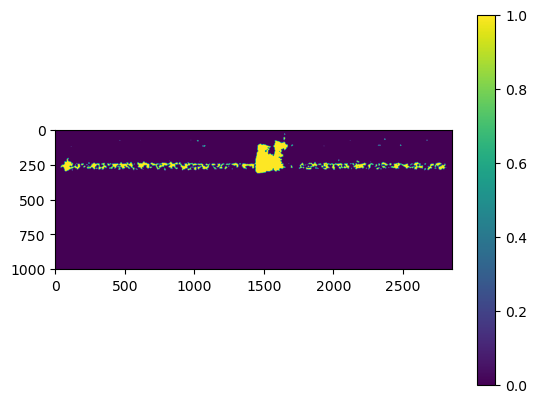

43501.88679245283


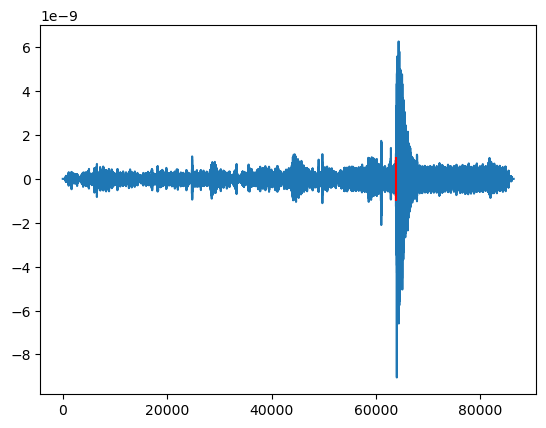

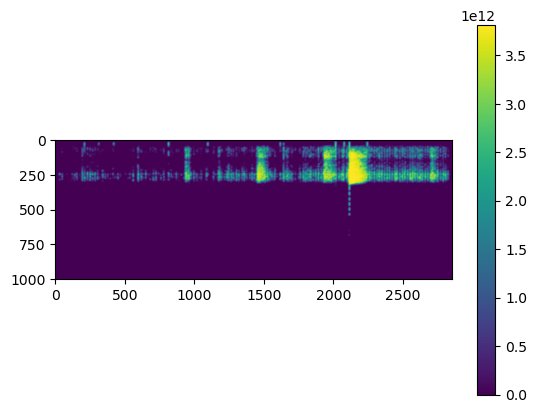

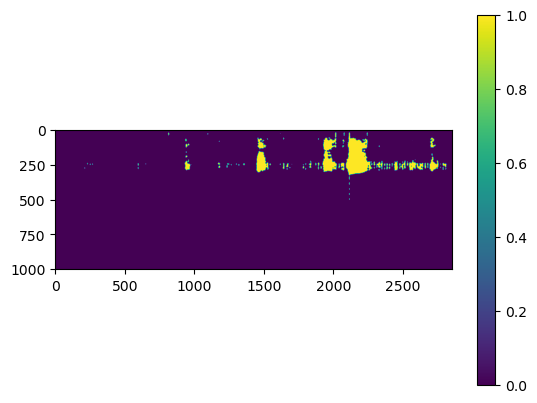

63788.67924528302


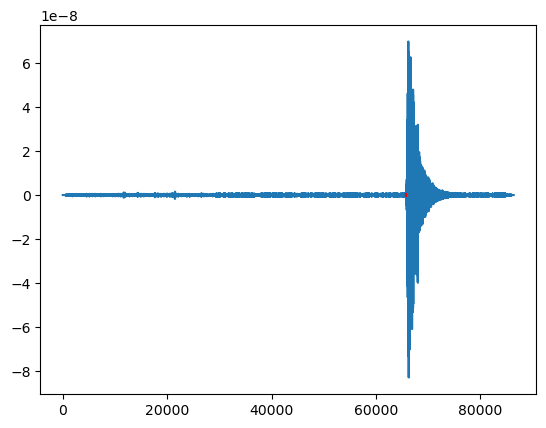

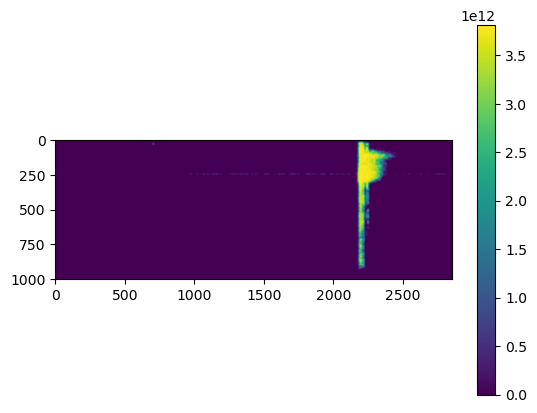

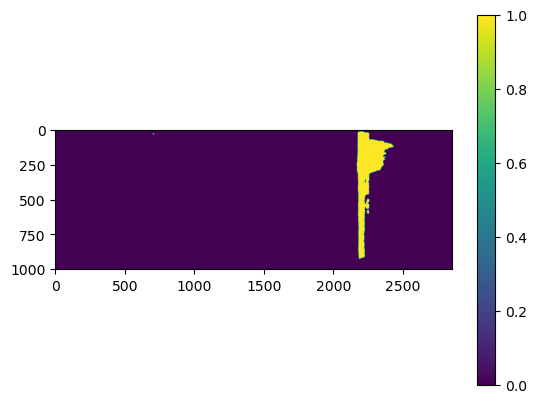

65690.56603773584


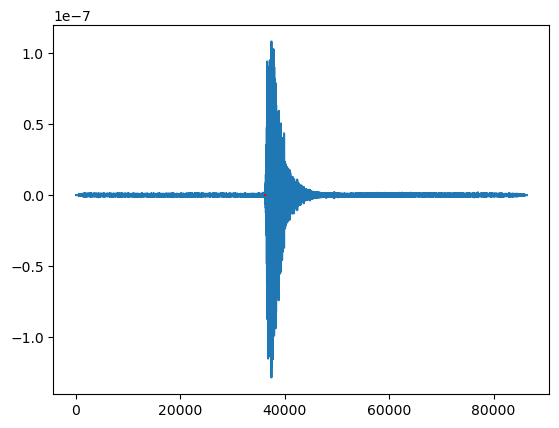

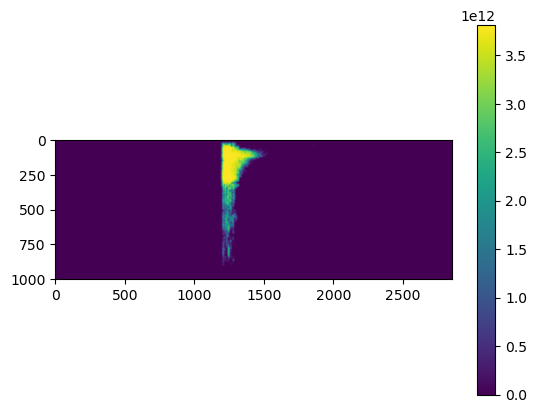

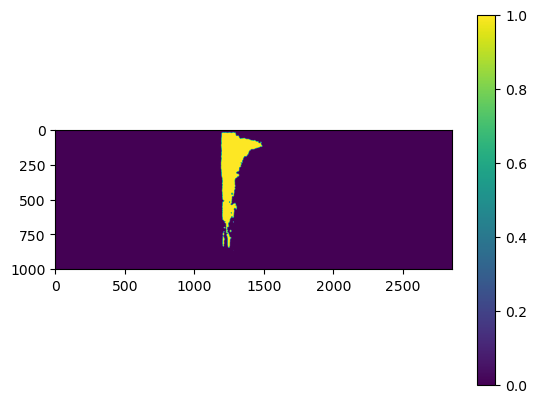

36286.79245283019


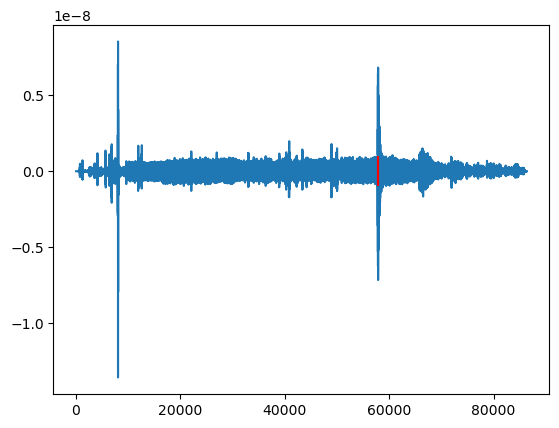

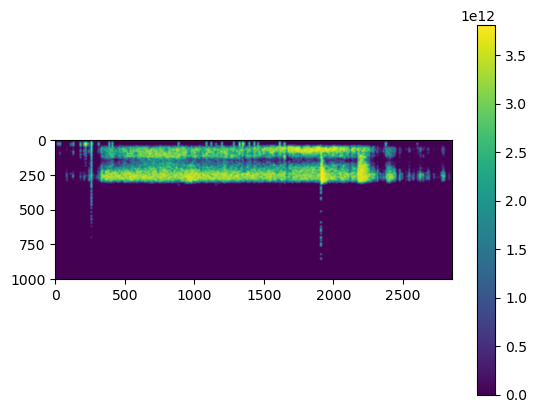

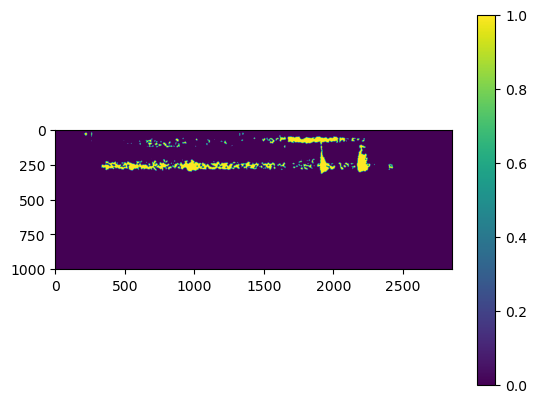

57781.1320754717


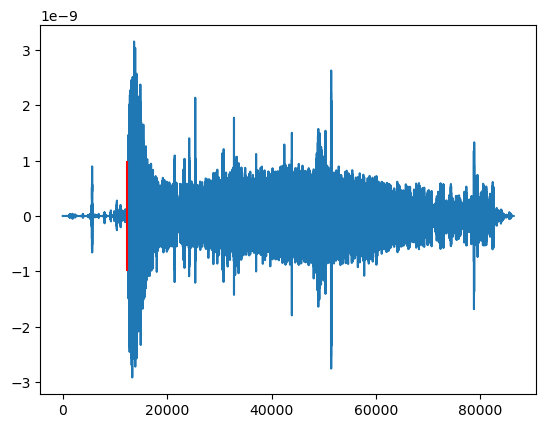

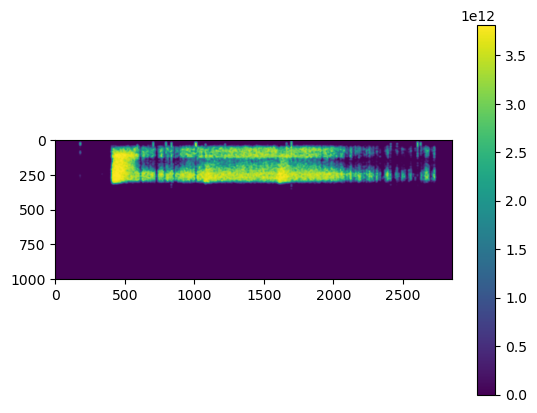

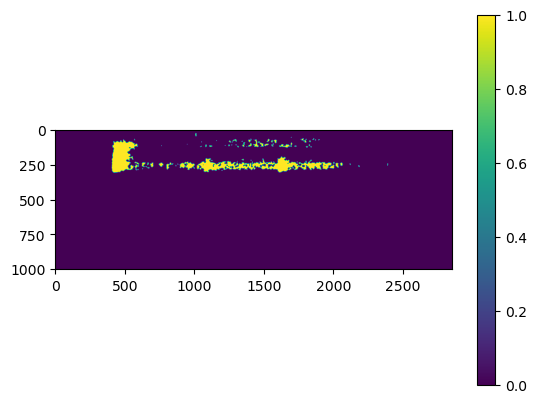

12226.415094339623


In [35]:
data = SismicDataset()
for i in range(76):
    x,y,f,t,sxx, label, index = data.__getitem__(i)
    plt.plot(y,x)
    plt.vlines(label,-1e-9,1e-9,color="red")
    plt.show()
   
   
   
    filter1 = sxx > np.mean(sxx)
    filter1 = filter1.astype(int)

    kernel = np.ones((5, 5))
    conv = ndimage.convolve(filter1, kernel, mode='reflect')
    for i in range(8):
        conv = ndimage.convolve(conv, kernel, mode='reflect')

    filter2 = conv > np.quantile(conv, q=0.97)
    filter2 = filter2.astype(int)
  
    plt.imshow(conv)
    plt.colorbar()
    plt.show()
    plt.imshow(filter2)
    plt.colorbar()
    plt.show()
    # plt.pcolormesh(t,f,sxx)
    #plt.show()

    print(t[index])